## **Aplicação HRNet**

In [1]:
import sys
sys.path.append('../../')

In [17]:
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np
import json
from pathlib import Path
import pandas as pd
from typing import Dict, List, Tuple, Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import optuna
import kornia
import seaborn as sns
from scipy.stats import pearsonr

# Importar sua classe existente
from notebooks.playground_VC.hrnet.configs_hrnet import get_default_config
from notebooks.playground_VC.hrnet.hrnet import HRNet
from src.vfss_dataset import VFSSImageDataset
from src.utils import get_script_relative_path, get_project_root_directory
from src.data_extraction.video_frame import create_video_frame_df, load_video_frame_metadata_from_csv
from src.split_data import split_data_k_fold
from src.utils import get_corners_from_angle
from src.target.heatmap import generate_heatmap_from_points
from src.utils import plot_image_with_mask

In [3]:
# UTILS
# =======================================

def clahe(img):
    img_clahe = kornia.enhance.equalize_clahe(img, clip_limit = 5.0)#, clip_limit=20.0, grid_size=(8, 8))
    return img_clahe

def modify_input(img):
    # Padroniza tudo para o formato (batch, filtro, H, W)
    if (len(img.shape) != 4):
        img = img.unsqueeze(0) 
    
    # Modifica cada uma das imagens
    list_imgs = []
    n_batch = img.shape[0]
    for i in range(n_batch):
        img_orig = img[i][0] # (filtro, H, W)

        # Aplica CLAHE
        img_clahe = clahe(img_orig)

        # Aplica Double CLAHE
        img_double_clahe = clahe(img_clahe)

        # Stack Channels
        img_channels = torch.stack([img_orig, img_clahe, img_double_clahe])

        # Stack Batch
        list_imgs.append(img_channels)

    img_new = torch.stack(list_imgs, dim = 0)
    
    return img_new

def custom_collate_fn(batch):
    """
    batch é uma lista de tuplas: [(frame, target_dict, meta), (frame, target_dict, meta), ...]
    """
    frames = torch.stack([item[0] for item in batch])  # Empilha os inputs (frames)
    
    # Agrupa os targets por chave
    target_dicts = [item[1] for item in batch]

    batched_targets = {}
    for key in target_dicts[0].keys():
        list_aux = []
        for td in target_dicts:
            list_aux.append(td[key])
        batched_targets[key] = torch.stack(list_aux)

    # Mantém os metadados como lista
    metas = [item[2] for item in batch]

    return frames, batched_targets, metas

In [4]:
# CONFIGURAÇÕES DE TREINAMENTO
# =======================================

class TrainingConfig:
    """Centraliza configurações de treinamento"""
    def __init__(
        self,
        learning_rate: float = 3e-4,
        batch_size: int = 8,
        epochs: int = 200,
        patience: int = 5,
        lr_patience: float = 1e-10,
        scheduler = None,
        criterion_heatmap = nn.MSELoss(),
        checkpoint_dir: str = "./checkpoints/hrnet_complete",
        device: str = "cuda"
    ):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.lr_patience = lr_patience
        self.scheduler = scheduler
        self.criterion_heatmap = criterion_heatmap
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.device = device

In [5]:
# GERENCIADOR DE CHECKPOINT
# =======================================

class CheckpointManager:
    """Gerencia salvamento e carregamento de checkpoints"""
    def __init__(self, checkpoint_dir: Path, fold: int):
        self.checkpoint_dir = checkpoint_dir
        self.fold = fold
        self.best_loss = float('inf')
        
    def save_checkpoint(
        self, 
        model: nn.Module, 
        optimizer: optim.Optimizer,
        epoch: int,
        val_loss: float,
        train_loss: float,
        is_best: bool = False
    ):
        """Salva checkpoint do modelo"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss,
            'fold': self.fold
        }
        
        # Salva checkpoint da última época
        last_path = self.checkpoint_dir / f"fold_{self.fold}_last.pth"
        torch.save(checkpoint, last_path)
        
        # Salva melhor modelo
        if is_best:
            best_path = self.checkpoint_dir / f"fold_{self.fold}_best.pth"
            torch.save(checkpoint, best_path)
            self.best_loss = val_loss
            print(f"✓ Melhor modelo salvo (val_loss: {val_loss:.4f})")
    
    def load_checkpoint(self, model: nn.Module, optimizer: optim.Optimizer, best: bool = True):
        """Carrega checkpoint"""
        suffix = "best" if best else "last"
        checkpoint_path = self.checkpoint_dir / f"fold_{self.fold}_{suffix}.pth"
        
        if not checkpoint_path.exists():
            print(f"Checkpoint não encontrado: {checkpoint_path}")
            return None
        
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print(f"✓ Checkpoint carregado: epoch {checkpoint['epoch']}, val_loss: {checkpoint['val_loss']:.4f}")
        return checkpoint


In [6]:
# CALCULADOR DA LOSS
# =======================================

class FocalMSELoss(nn.Module):
    def __init__(self, alpha=2.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        # L2 básico
        mse = (pred - target) ** 2
        
        # fator de foco baseado na região do pico
        focal_weight = 1 + self.alpha * (target ** self.gamma)
        
        # aplica foco
        loss = focal_weight * mse
        
        return loss.mean()

class FocalMSEMaskedLoss(nn.Module):
    def __init__(self, alpha=2.0, gamma=2.0, threshold=1e-3):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.threshold = threshold

    def forward(self, pred, target):
        # L2 básico
        mse = (pred - target) ** 2
        
        # Focal: dá mais peso onde o GT é alto
        focal_weight = 1 + self.alpha * (target ** self.gamma)
        focal_mse = focal_weight * mse
        
        # MÁSCARA: só considera o que é relevante
        mask = (target > self.threshold).float()
        
        # Aplica máscara e evita divisões por zero
        masked_loss = (focal_mse * mask)
        
        if mask.sum() == 0:
            return focal_mse.mean()   # fallback
            
        return masked_loss.sum() / mask.sum()

class LossCalculator:
    """Centraliza o cálculo de perdas"""
    def __init__(self, criterion_heatmap, config: TrainingConfig):
        self.criterion_heatmap = criterion_heatmap
        self.config = config
    
    def calculate_loss(self, pred_heatmap, gt_heatmap):
        """Calcula perda combinada"""
        loss_heatmap = self.criterion_heatmap(pred_heatmap, gt_heatmap)
        
        loss_total = (
            loss_heatmap
        )
        
        return loss_total, {
            'heatmap': loss_heatmap.item(),
        }


In [7]:
# TREINA UMA ÉPOCA
# ======================================= 

def train_one_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    loss_calculator: LossCalculator,
    optimizer: optim.Optimizer,
    device: str,
    modify_input_fn: Callable,
    accumulation_steps: int = 2,
    scaler: torch.cuda.amp.GradScaler = None
) -> Tuple[float, Dict]:
    """
    Treina uma época com gradient accumulation e mixed precision
    
    Args:
        model: Modelo a ser treinado
        train_loader: DataLoader de treino
        loss_calculator: Calculadora de loss
        optimizer: Otimizador
        device: 'cuda' ou 'cpu'
        modify_input_fn: Função para modificar inputs (ex: resize)
        accumulation_steps: Número de steps para acumular gradientes
        scaler: GradScaler para mixed precision (opcional)
    
    Returns:
        avg_loss: Loss média da época
        avg_components: Componentes da loss (dict)
    """
    
    model.train()
    running_loss = 0.0
    loss_components = {'heatmap': 0.0}
    
    # Zero grad no início
    optimizer.zero_grad()
    
    # Usar enumerate com total para tqdm
    for batch_idx, (inputs, targets, _) in enumerate(tqdm(train_loader, desc="Treinando")):
        
        # Mover para GPU
        inputs = inputs.to(device, non_blocking=True)
        inputs = modify_input_fn(inputs)
        gt_heatmap = targets['heatmap'].to(device, non_blocking=True)
        gt_heatmap = F.interpolate(gt_heatmap, size=(64, 64), mode='bilinear', align_corners=False)
        
        # Forward pass com ou sem mixed precision
        if scaler is not None:
            with torch.cuda.amp.autocast():
                pred_heatmap = model(inputs)
                loss_total, components = loss_calculator.calculate_loss(
                    pred_heatmap, gt_heatmap
                )
            
            # Dividir loss pela acumulação
            loss_scaled = loss_total / accumulation_steps
            
            # Backward com scaler
            scaler.scale(loss_scaled).backward()
        
        else:
            pred_heatmap = model(inputs)
            loss_total, components = loss_calculator.calculate_loss(
                pred_heatmap, gt_heatmap
            )
            
            loss_scaled = loss_total / accumulation_steps
            loss_scaled.backward()
        
        # Acumular stats (usar loss ORIGINAL, não scaled)
        running_loss += loss_total.item()
        for key in components:
            if key in loss_components:
                loss_components[key] += components[key]
            else:
                loss_components[key] = components[key]
        
        # Atualizar pesos a cada N steps
        if (batch_idx + 1) % accumulation_steps == 0:
            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            
            optimizer.zero_grad()
    
    # Apenas se houver gradientes não processados - últimos gradientes calculados
    if len(train_loader) % accumulation_steps != 0:
        if scaler is not None:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        
        optimizer.zero_grad()
    
    # Calcular médias (proteger contra divisão por zero)
    n_batches = len(train_loader)
    if n_batches == 0:
        return 0.0, loss_components
    
    avg_loss = running_loss / n_batches
    avg_components = {k: v / n_batches for k, v in loss_components.items()}
    
    return avg_loss, avg_components

In [8]:
# VALIDAÇÃO
# =======================================

def validate(
    model: nn.Module,
    val_loader: DataLoader,
    loss_calculator: LossCalculator,
    device: str,
    modify_input_fn: Callable
) -> Tuple[float, Dict]:
    """Valida o modelo"""
    model.eval()
    val_loss = 0.0
    loss_components = {'heatmap': 0.0}
    
    with torch.no_grad():
        for inputs, targets, _ in val_loader:

            # Manda pra GPU
            inputs = inputs.to(device, non_blocking=True)
            inputs = modify_input_fn(inputs)
            gt_heatmap = targets['heatmap'].to(device)
            gt_heatmap = F.interpolate(gt_heatmap, size=(64, 64), mode='bilinear', align_corners=False)
            
            pred_heatmap = model(inputs)
            
            loss_total, components = loss_calculator.calculate_loss(
                pred_heatmap, gt_heatmap
            )
            
            val_loss += loss_total.item()
            for key in loss_components:
                loss_components[key] += components[key]
    
    n_batches = len(val_loader)
    avg_loss = val_loss / n_batches
    avg_components = {k: v / n_batches for k, v in loss_components.items()}
    
    return avg_loss, avg_components


In [9]:
# TREINA UM FOLD
# ======================================= 

def train_one_fold(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: TrainingConfig,
    fold: int,
    modify_input_fn: Callable
) -> Tuple[nn.Module, List[Dict]]:
    """Treina um fold completo com early stopping e checkpoints"""
    
    model.to(config.device)
    
    # Configuração
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = config.scheduler(
        optimizer,
        mode="min",
        factor=0.1,
        patience=config.patience // 3,  # Quando ver que o negócio tá ficando esquisito, mexe.
    )
    
    loss_calculator = LossCalculator(config.criterion_heatmap, config)
    checkpoint_manager = CheckpointManager(config.checkpoint_dir, fold)
    
    # Tracking
    best_val_loss = float('inf')
    patience_counter = 0
    history = []
    
    for epoch in range(config.epochs):
        
        scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
        
        # Treino
        train_loss, train_components = train_one_epoch(
            model, train_loader, loss_calculator, optimizer,
            config.device, modify_input_fn, scaler = scaler
        )
        
        # Validação
        val_loss, val_components = validate(
            model, val_loader, loss_calculator, config.device, modify_input_fn
        )

        # Scheduler
        scheduler.step(val_loss)
        
        # Logging
        epoch_info = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_components': train_components,
            'val_components': val_components,
            'lr': optimizer.param_groups[0]['lr']
        }
        history.append(epoch_info)
        
        print(f"Época {epoch+1}/{config.epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"  Heatmap: {val_components['heatmap']:.4f}, ")
        

        # Scheduler Early Stopping (Learning Rate)
        if optimizer.param_groups[0]["lr"] <= config.lr_patience:
            print("LR mínima atingida, parando.")
            break

        # Checkpoint e Early Stopping
        is_best = val_loss < best_val_loss
        checkpoint_manager.save_checkpoint(
            model, optimizer, epoch, val_loss, train_loss, is_best
        )
        
        if is_best:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config.patience:
                print(f"Early stopping ativado na época {epoch+1}")
                break
    
    # Carrega melhor modelo
    checkpoint_manager.load_checkpoint(model, optimizer, best=True)
    
    return model, history

In [10]:
# VALIDAÇÃO CRUZADA
# ======================================= 

def cross_validate(
    model_class,
    folds: List[pd.DataFrame],
    config: TrainingConfig,
    target: str,
    output_dim: Tuple[int, int],
    modify_input_fn: Callable,
    dataset_class,
    sigma: float,
    collate_fn: Callable,
    model_kwargs: Dict = None
) -> Dict:
    """Executa validação cruzada K-Fold"""
    
    model_kwargs = model_kwargs or {}
    k = len(folds)
    results = {
        'fold_losses': [],
        'fold_histories': [],
        'best_fold': None,
        'best_loss': float('inf')
    }
    
    for i in range(k):
        print(f"\n{'='*50}")
        print(f"FOLD {i+1}/{k}")
        print(f"{'='*50}")
        
        # Preparação dos dados
        df_val = folds[i]
        df_train = pd.concat([folds[j] for j in range(k) if j != i], ignore_index=True)
        
        train_set = dataset_class(df_train, target, output_dim, sigma = sigma)
        val_set = dataset_class(df_val, target, output_dim, sigma = sigma)
        
        train_loader = DataLoader(
            train_set, batch_size=config.batch_size, shuffle=True,
            collate_fn=collate_fn, num_workers=0, pin_memory=True#, persistent_workers=True
        )
        val_loader = DataLoader(
            val_set, batch_size=config.batch_size, shuffle=False,
            collate_fn=collate_fn, num_workers=0, pin_memory=True#, persistent_workers=True
        )
        
        # Novo modelo para cada fold
        model = model_class(model_kwargs)
        
        # Treina fold
        model, history = train_one_fold(
            model, train_loader, val_loader, config, i+1, modify_input_fn
        )
        
        # Validação final
        final_val_loss, _ = validate(
            model, val_loader, 
            LossCalculator(config.criterion_heatmap, config),
            config.device, modify_input_fn
        )
        
        results['fold_losses'].append(final_val_loss)
        results['fold_histories'].append(history)
        
        # Atualiza melhor fold
        if final_val_loss < results['best_loss']:
            results['best_loss'] = final_val_loss
            results['best_fold'] = i + 1
        
        print(f"\nFold {i+1} Loss Final: {final_val_loss:.4f}")
    
    # Estatísticas finais
    results['mean_loss'] = np.mean(results['fold_losses'])
    results['std_loss'] = np.std(results['fold_losses'])
    
    print(f"\n{'='*50}")
    print(f"RESULTADOS FINAIS")
    print(f"{'='*50}")
    print(f"Média dos Folds: {results['mean_loss']:.4f} ± {results['std_loss']:.4f}")
    print(f"Melhor Fold: {results['best_fold']} (Loss: {results['best_loss']:.4f})")
    
    # Salva resultados
    results_path = config.checkpoint_dir / "cross_validation_results.json"
    with open(results_path, 'w') as f:
        json.dump({
            'fold_losses': results['fold_losses'],
            'mean_loss': results['mean_loss'],
            'std_loss': results['std_loss'],
            'best_fold': results['best_fold'],
            'best_loss': results['best_loss']
        }, f, indent=2)
    
    return results

In [11]:
# TUNAGEM DE HIPERPARÂMETROS
# ======================================= 

def objective_optuna(
    trial: optuna.Trial,
    model_class,
    folds: List[pd.DataFrame],
    target: str,
    output_dim: Tuple[int, int],
    modify_input_fn: Callable,
    dataset_class,
    sigma: float,
    collate_fn: Callable,
    device: str,
    epochs: int,
    model_kwargs: Dict = None
) -> float:
    """Função objetivo para otimização Optuna"""
    
    # Hiperparâmetros a serem otimizados
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])
    
    # Configuração com hiperparâmetros sugeridos
    config = TrainingConfig(
        learning_rate=lr,
        batch_size=batch_size,
        epochs=epochs,  # Reduzido para Optuna
        patience=10,
        checkpoint_dir=f"./optuna_trials/trial_{trial.number}",
        device=device
    )
    
    # Executa cross-validation
    results = cross_validate(
        model_class, folds, config, target, output_dim,
        modify_input_fn, dataset_class, collate_fn, model_kwargs
    )

    # Limpa memória após cada trial
    torch.cuda.empty_cache()
    
    # Pruning - reporta loss intermediária para parar trials ruins
    # Optuna pode cancelar trials que claramente não vão dar certo
    trial.report(results['mean_loss'], step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return results['mean_loss']


def tune_hyperparameters(
    model_class,
    folds: List[pd.DataFrame],
    target: str,
    output_dim: Tuple[int, int],
    modify_input_fn: Callable,
    dataset_class,
    sigma: float,
    collate_fn: Callable,
    device: str,
    epochs: int = 50,
    n_trials: int = 20,
    model_kwargs: Dict = None
) -> optuna.Study:
    """Tunagem de hiperparâmetros com Optuna"""
    
    study = optuna.create_study(
        direction="minimize",
        study_name="hrnet_complete_hyperparameter_tuning"
    )
    
    study.optimize(
        lambda trial: objective_optuna(
            trial, model_class, folds, target, output_dim,
            modify_input_fn, dataset_class, sigma, collate_fn, device, epochs, model_kwargs
        ),
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    print("\n" + "="*50)
    print("MELHORES HIPERPARÂMETROS")
    print("="*50)
    print(f"Melhor Loss: {study.best_value:.4f}")
    print("Parâmetros:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study

In [12]:
# VISUALIZAÇÃO E ANÁLISE DE RESULTADOS
# ======================================= 

class TestEvaluator:
    """Avalia modelo no conjunto de teste e gera visualizações"""
    
    def __init__(
        self,
        model_class,
        model_kwargs: Dict,
        checkpoint_path: str,
        device: str,
        modify_input_fn: Callable
    ):
        self.model_class = model_class
        self.model_kwargs = model_kwargs or {}
        self.device = device
        self.modify_input_fn = modify_input_fn
        
        # Carrega modelo
        self.model = model_class(self.model_kwargs).to(device)
        checkpoint = torch.load(checkpoint_path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        print(f"✓ Modelo carregado: {checkpoint_path}")
        print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"  Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
    
    def extract_keypoints_from_heatmap(self, heatmap: torch.Tensor) -> torch.Tensor:
        """Extrai coordenadas dos keypoints do heatmap"""
        num_keypoints = heatmap.shape[0]
        points = torch.zeros(num_keypoints, 2)
        
        for k in range(num_keypoints):
            heatmap_k = heatmap[k].cpu().numpy()
            idx = np.unravel_index(np.argmax(heatmap_k), heatmap_k.shape)
            points[k] = torch.tensor([idx[0], idx[1]])  # (y, x)
        
        return points
    
    def euclidean_distance(self, point1: torch.Tensor, point2: torch.Tensor) -> float:
        """Calcula distância euclidiana entre dois pontos"""
        return torch.sqrt(torch.sum((point1 - point2) ** 2)).item()
    
    def evaluate_test_set(
        self,
        test_dataset,
        loss_calculator: LossCalculator
    ) -> Dict:
        """Avalia modelo no conjunto de teste"""
        
        num_keypoints = 2
        
        results = {
            'keypoint_distances': [[] for _ in range(num_keypoints)],
            'total_losses': [],
            'predictions': [],
            'ground_truths': [],
            'images': []
        }
        
        print(f"\nAvaliando {len(test_dataset)} amostras do conjunto de teste...")
        
        for idx in tqdm(range(len(test_dataset)), desc="Avaliando"):
            input_img, target, _ = test_dataset[idx]
            
            # Preparação
            input_tensor = self.modify_input_fn(input_img).float().to(self.device)
            gt_heatmap = target['heatmap'].float().to(self.device).unsqueeze(0)
            gt_heatmap = F.interpolate(gt_heatmap, size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
            
            # Inferência
            with torch.no_grad():
                pred_heatmap = self.model(input_tensor)
            
            pred_heatmap = pred_heatmap.squeeze(0)
            
            # Extrai pontos
            gt_points = self.extract_keypoints_from_heatmap(gt_heatmap)
            pred_points = self.extract_keypoints_from_heatmap(pred_heatmap)
            
            # Calcula distâncias por keypoint
            for k in range(num_keypoints):
                dist = self.euclidean_distance(gt_points[k], pred_points[k])
                results['keypoint_distances'][k].append(dist)
            
            # Calcula losses
            loss_total, components = loss_calculator.calculate_loss(
                pred_heatmap, gt_heatmap
            )
            
            results['total_losses'].append(loss_total.item())
            
            # Armazena para visualização
            results['predictions'].append({
                'points': pred_points,
                'heatmap': pred_heatmap.cpu(),
            })
            results['ground_truths'].append({
                'points': gt_points,
                'heatmap': gt_heatmap.cpu(),
            })
            results['images'].append(input_tensor.squeeze(0).cpu())
        
        # Converte para arrays
        for k in range(num_keypoints):
            results['keypoint_distances'][k] = np.array(results['keypoint_distances'][k])
        results['total_losses'] = np.array(results['total_losses'])
        
        return results
    
    def plot_loss_distributions(
        self,
        results: Dict,
        save_path: str = None
    ):
        """Plota histogramas das distribuições de loss"""
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        fig.suptitle('Distribuição das Losses no Conjunto de Teste', fontsize=16, y=1.0)
        
        # 1. Total Loss
        ax.hist(results['total_losses'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(results['total_losses']), color='red', linestyle='--',
                   label=f'Média: {np.mean(results["total_losses"]):.4f}')
        ax.axvline(np.median(results['total_losses']), color='green', linestyle='--',
                   label=f'Mediana: {np.median(results["total_losses"]):.4f}')
        ax.set_xlabel('Total Loss')
        ax.set_ylabel('Frequência')
        ax.set_title('Distribuição: Total Loss')
        ax.legend()
        ax.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Gráfico salvo: {save_path}")
        
        plt.show()
    
    def plot_keypoint_analysis(
        self,
        results: Dict,
        save_path: str = None
    ):
        """Plota análise detalhada por keypoint"""
        
        num_keypoints = len(results['keypoint_distances'])
        fig, axes = plt.subplots(1, num_keypoints, figsize=(6*num_keypoints, 5))
        
        if num_keypoints == 1:
            axes = [axes]
        
        fig.suptitle('Análise de Distâncias por Keypoint', fontsize=16)
        
        for k in range(num_keypoints):
            ax = axes[k]
            distances = results['keypoint_distances'][k]
            
            # Histograma
            ax.hist(distances, bins=30, color='orange', edgecolor='black', alpha=0.7)
            
            # Estatísticas
            mean_dist = np.mean(distances)
            median_dist = np.median(distances)
            std_dist = np.std(distances)
            
            ax.axvline(mean_dist, color='red', linestyle='--', linewidth=2,
                      label=f'Média: {mean_dist:.2f}px')
            ax.axvline(median_dist, color='green', linestyle='--', linewidth=2,
                      label=f'Mediana: {median_dist:.2f}px')
            
            ax.set_xlabel('Distância Euclidiana (pixels)')
            ax.set_ylabel('Frequência')
            ax.set_title(f'Keypoint {k+1}\n(Std: {std_dist:.2f}px)')
            ax.legend()
            ax.grid(alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Gráfico salvo: {save_path}")
        
        plt.show()
    
    def visualize_predictions(
        self,
        results: Dict,
        metric_type: str = 'total_loss',
        save_path: str = None
    ):
        """Visualiza melhor, mediana e pior predição por keypoint"""
        
        num_keypoints = len(results['keypoint_distances'])
        
        for k in range(num_keypoints):
            print(f"\n--- Visualizações para Keypoint {k+1} ---")
            
            # Define métrica
            if metric_type == 'distance':
                metric = results['keypoint_distances'][k]
                metric_name = "Distância Euclidiana"
            else:  # total_loss
                metric = results['total_losses']
                metric_name = "Total Loss"
            
            # Encontra índices
            idx_min = np.argmin(metric)
            idx_max = np.argmax(metric)
            idx_med = np.argsort(metric)[len(metric)//2]
            
            indices = [idx_min, idx_med, idx_max]
            values = [metric[idx_min], metric[idx_med], metric[idx_max]]
            titles = ["Melhor Caso", "Caso Mediano", "Pior Caso"]
            
            # Cria figura
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            fig.suptitle(f'Keypoint {k+1} - Análise por {metric_name}', fontsize=16)
            
            for col, (idx, val, title) in enumerate(zip(indices, values, titles)):
                # Imagem original com pontos
                ax_img = axes[0, col]
                img = results['images'][idx][0].numpy()

                # Converter para tensor
                img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # Adiciona dimensão batch

                # Resize para 64x64
                img_resized = F.interpolate(
                    img_tensor,
                    size=(64, 64),
                    mode='bilinear',
                    align_corners=False
                )

                # Converter de volta para numpy
                img = img_resized.squeeze(0).squeeze(0).numpy()
                ax_img.imshow(img, cmap='gray')
                
                # Ground truth
                gt_point = results['ground_truths'][idx]['points'][k]
                ax_img.scatter(gt_point[1], gt_point[0], color='lime', marker='x', 
                              s=150, linewidths=3, label='Ground Truth')
                
                # Predição
                pred_point = results['predictions'][idx]['points'][k]
                ax_img.scatter(pred_point[1], pred_point[0], color='red', marker='o',
                              s=100, linewidths=2, label='Predição')
                
                # Linha conectando
                ax_img.plot([gt_point[1], pred_point[1]], [gt_point[0], pred_point[0]],
                           'yellow', linewidth=2, alpha=0.7)
                
                dist = self.euclidean_distance(gt_point, pred_point)
                ax_img.set_title(f'{title}\n{metric_name}: {val:.4f}\nDist: {dist:.2f}px')
                ax_img.axis('off')
                ax_img.legend(loc='upper right')
                
                # Heatmap predito
                ax_heat = axes[1, col]
                pred_heatmap = results['predictions'][idx]['heatmap'][k].numpy()
                im = ax_heat.imshow(pred_heatmap, cmap='hot')
                ax_heat.scatter(pred_point[1], pred_point[0], color='cyan', marker='o',
                               s=100, linewidths=2)
                ax_heat.set_title('Heatmap Predito')
                ax_heat.axis('off')
                plt.colorbar(im, ax=ax_heat, fraction=0.046)
            
            plt.tight_layout()
            
            if save_path:
                path_final = f"{save_path}_keypoint{k+1}.png"
                plt.savefig(path_final, dpi=300, bbox_inches='tight')
                print(f"✓ Figura salva: {path_final}")
            
            plt.show()
    
    def generate_report(self, results: Dict, save_path: str = None):
        """Gera relatório textual completo"""
        
        report = []
        report.append("="*70)
        report.append("RELATÓRIO DE AVALIAÇÃO NO CONJUNTO DE TESTE")
        report.append("="*70)
        report.append(f"\nNúmero de amostras: {len(results['total_losses'])}")
        
        # Loss Total
        report.append("\n" + "-"*70)
        report.append("LOSS TOTAL")
        report.append("-"*70)
        report.append(f"Média:    {np.mean(results['total_losses']):.6f}")
        report.append(f"Mediana:  {np.median(results['total_losses']):.6f}")
        report.append(f"Std:      {np.std(results['total_losses']):.6f}")
        report.append(f"Min:      {np.min(results['total_losses']):.6f}")
        report.append(f"Max:      {np.max(results['total_losses']):.6f}")
        
        # Por keypoint
        num_keypoints = len(results['keypoint_distances'])
        for k in range(num_keypoints):
            distances = results['keypoint_distances'][k]
            report.append("\n" + "-"*70)
            report.append(f"KEYPOINT {k+1} - DISTÂNCIA EUCLIDIANA (pixels)")
            report.append("-"*70)
            report.append(f"Média:    {np.mean(distances):.2f}")
            report.append(f"Mediana:  {np.median(distances):.2f}")
            report.append(f"Std:      {np.std(distances):.2f}")
            report.append(f"Min:      {np.min(distances):.2f}")
            report.append(f"Max:      {np.max(distances):.2f}")
            report.append(f"Quartis:  Q1={np.percentile(distances, 25):.2f}, "
                         f"Q3={np.percentile(distances, 75):.2f}")
        
        report.append("\n" + "="*70)
        
        report_text = "\n".join(report)
        print(report_text)
        
        if save_path:
            with open(save_path, 'w', encoding='utf-8') as f:
                f.write(report_text)
            print(f"\n✓ Relatório salvo: {save_path}")
        
        return report_text

In [13]:
# INFERÊNCIA
# ======================================= 

def evaluate_model_on_test(
    model_class,
    model_kwargs: Dict,
    checkpoint_path: str,
    test_dataset,
    config: TrainingConfig,
    modify_input_fn: Callable,
    output_dir: str = "./evaluation_results"
):
    """
    Pipeline completo de avaliação no conjunto de teste
    
    Args:
        model_class: Classe do modelo
        model_kwargs: Argumentos do modelo
        checkpoint_path: Caminho do checkpoint a ser avaliado
        test_dataset: Dataset de teste
        config: Configuração de treinamento
        modify_input_fn: Função para modificar input
        output_dir: Diretório para salvar resultados
    """
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    print("\n" + "="*70)
    print("INICIANDO AVALIAÇÃO NO CONJUNTO DE TESTE")
    print("="*70)
    
    # Inicializa avaliador
    evaluator = TestEvaluator(
        model_class=model_class,
        model_kwargs=model_kwargs,
        checkpoint_path=checkpoint_path,
        device=config.device,
        modify_input_fn=modify_input_fn
    )
    
    # Avalia conjunto de teste
    loss_calculator = LossCalculator(
        criterion_heatmap=config.criterion_heatmap,
        config=config
    )
    
    results = evaluator.evaluate_test_set(test_dataset, loss_calculator)
    
    # Gera visualizações
    print("\n" + "="*70)
    print("GERANDO VISUALIZAÇÕES")
    print("="*70)
    
    # 1. Distribuições de loss
    evaluator.plot_loss_distributions(
        results,
        save_path=str(output_path / "loss_distributions.png")
    )
    
    # 2. Análise por keypoint
    evaluator.plot_keypoint_analysis(
        results,
        save_path=str(output_path / "keypoint_analysis.png")
    )
    
    # 3. Visualizações de predições (por distância)
    evaluator.visualize_predictions(
        results,
        metric_type='distance',
        save_path=str(output_path / "predictions_by_distance")
    )
    
    # 4. Visualizações de predições (por total loss)
    evaluator.visualize_predictions(
        results,
        metric_type='total_loss',
        save_path=str(output_path / "predictions_by_loss")
    )
    
    # 5. Gera relatório
    evaluator.generate_report(
        results,
        save_path=str(output_path / "evaluation_report.txt")
    )
    
    print("\n" + "="*70)
    print("AVALIAÇÃO CONCLUÍDA!")
    print(f"Resultados salvos em: {output_path}")
    print("="*70)
    
    return results

In [14]:
# APLICAÇÃO - INICIALIZAÇÃO
# ======================================= 

# Configuração
config = TrainingConfig(
    learning_rate=3e-4,
    batch_size=8,
    epochs=200,
    patience=10,
    lr_patience = 1e-10,
    criterion_heatmap= FocalMSEMaskedLoss(),
    scheduler = optim.lr_scheduler.ReduceLROnPlateau,
    checkpoint_dir="..\\..\\data\\model_weights\\hrnet_complete\\FocalMSEMaskedLoss_200ep",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

sigma_heatmap = 20

# Parâmetros do modelo
target = "heatmap+roi+points"
output_dim = (256, 256)
model_kwargs = get_default_config()


videos_dir = '..\\data\\videos\\' 
labels_dir = '..\\data\\rotulos\\anotacoes-tecgraf\\'
frames_dir = '..\\data\\frames'
path_dataframe = "data\\metadados\\video_frame_metadata.csv"

root = get_project_root_directory()
path_dataframe = os.path.join(root, path_dataframe)
video_frame_df = pd.read_csv(path_dataframe)
#video_frame_df = video_frame_df.replace(r"\\", "/", regex=True)

print("\nSplit Dados")
list_df_folds, df_test = split_data_k_fold(video_frame_df, test_size=0.2, n_folds=5)



Split Dados
Folds all: 92
Test: 23
Overall Dataset - Videos: 234 | Patients: 115 | Frames: 814 (100.0%)
Training + Validation Set - Videos: 192 | Patients: 92 | Frames: 668 (82.1%)
Test Set - Videos: 42 | Patients: 23 | Frames: 146 (17.9%)

Fold 1 - Videos: 41 | Patients: 19 | Frames: 145 (17.8%)
Fold 2 - Videos: 56 | Patients: 19 | Frames: 183 (22.5%)
Fold 3 - Videos: 40 | Patients: 18 | Frames: 155 (19.0%)
Fold 4 - Videos: 26 | Patients: 18 | Frames: 95 (11.7%)
Fold 5 - Videos: 29 | Patients: 18 | Frames: 90 (11.1%)


,split_name,n_videos,n_patients,n_frames,percentage_of_initial_frames,video_ids
0,fold_1,41,19,145,0.178133,"[101, 102, 103, 104, 105, 106, 107, 108, 109, ..."
1,fold_2,56,19,183,0.224816,"[129, 130, 131, 132, 136, 137, 138, 139, 140, ..."
2,fold_3,40,18,155,0.190418,"[122, 123, 125, 126, 127, 128, 152, 153, 154, ..."
3,fold_4,26,18,95,0.116708,"[10, 113, 114, 115, 116, 117, 118, 119, 120, 1..."
4,fold_5,29,18,90,0.110565,"[192, 193, 194, 195, 196, 197, 198, 199, 200, ..."
5,test_set,42,23,146,0.179361,"[100, 11, 13, 142, 143, 144, 145, 146, 147, 14..."


In [15]:
# APLICAÇÃO - TREINO
# ======================================= 

# Cross-validation sem tunagem

results = cross_validate(
    model_class=HRNet,
    folds=list_df_folds,
    config=config,
    target=target,
    output_dim=output_dim,
    modify_input_fn=modify_input,
    dataset_class=VFSSImageDataset,
    sigma = sigma_heatmap,
    collate_fn=custom_collate_fn,
    model_kwargs=model_kwargs
)

"""

# Tunagem de hiperparâmetros com Optuna

study = tune_hyperparameters(
    model_class=HRNet,
    folds=list_df_folds,
    target=target,
    output_dim=output_dim,
    modify_input_fn=modify_input,
    dataset_class=VFSSImageDataset,
    sigma = sigma_heatmap,
    collate_fn=custom_collate_fn,
    device=config.device,
    n_trials=5,
    epochs = 5,
    model_kwargs=model_kwargs
)

# Treina com melhores hiperparâmetros
best_config = TrainingConfig(
    learning_rate=study.best_params['lr'],
    batch_size=study.best_params['batch_size'],
    epochs=25,   # Usar uma epoca maior, visto que é o melhor modelo... 
    patience=5,
    lr_patience = 1e-10,
    criterion_heatmap= FocalMSEMaskedLoss(),
    scheduler = optim.lr_scheduler.ReduceLROnPlateau,
    checkpoint_dir="..\\..\\data\\model_weights\\hrnet_complete_tunning",
    device=config.device
)

final_results = cross_validate(
    model_class=HRNet,
    folds=list_df_folds,
    config=best_config,
    target=target,
    output_dim=output_dim,
    modify_input_fn=modify_input,
    dataset_class=VFSSImageDataset,
    sigma=sigma_heatmap,
    collate_fn=custom_collate_fn,
    model_kwargs=model_kwargs
)
"""


FOLD 1/5


Treinando: 100%|██████████| 66/66 [01:46<00:00,  1.62s/it]


Época 1/200
  Train Loss: 0.1680 | Val Loss: 0.1559
  Heatmap: 0.1559, 
✓ Melhor modelo salvo (val_loss: 0.1559)


Treinando: 100%|██████████| 66/66 [01:38<00:00,  1.49s/it]


Época 2/200
  Train Loss: 0.0935 | Val Loss: 0.1234
  Heatmap: 0.1234, 
✓ Melhor modelo salvo (val_loss: 0.1234)


Treinando: 100%|██████████| 66/66 [01:35<00:00,  1.45s/it]


Época 3/200
  Train Loss: 0.0778 | Val Loss: 0.1138
  Heatmap: 0.1138, 
✓ Melhor modelo salvo (val_loss: 0.1138)


Treinando: 100%|██████████| 66/66 [01:37<00:00,  1.48s/it]


Época 4/200
  Train Loss: 0.0627 | Val Loss: 0.1027
  Heatmap: 0.1027, 
✓ Melhor modelo salvo (val_loss: 0.1027)


Treinando: 100%|██████████| 66/66 [01:39<00:00,  1.50s/it]


Época 5/200
  Train Loss: 0.0516 | Val Loss: 0.1007
  Heatmap: 0.1007, 
✓ Melhor modelo salvo (val_loss: 0.1007)


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.40s/it]


Época 6/200
  Train Loss: 0.0443 | Val Loss: 0.1123
  Heatmap: 0.1123, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 7/200
  Train Loss: 0.0379 | Val Loss: 0.1201
  Heatmap: 0.1201, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.38s/it]


Época 8/200
  Train Loss: 0.0281 | Val Loss: 0.0924
  Heatmap: 0.0924, 
✓ Melhor modelo salvo (val_loss: 0.0924)


Treinando: 100%|██████████| 66/66 [01:30<00:00,  1.38s/it]


Época 9/200
  Train Loss: 0.0224 | Val Loss: 0.1073
  Heatmap: 0.1073, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 10/200
  Train Loss: 0.0190 | Val Loss: 0.0988
  Heatmap: 0.0988, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.38s/it]


Época 11/200
  Train Loss: 0.0164 | Val Loss: 0.0899
  Heatmap: 0.0899, 
✓ Melhor modelo salvo (val_loss: 0.0899)


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.40s/it]


Época 12/200
  Train Loss: 0.0138 | Val Loss: 0.0910
  Heatmap: 0.0910, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 13/200
  Train Loss: 0.0115 | Val Loss: 0.0940
  Heatmap: 0.0940, 


Treinando: 100%|██████████| 66/66 [01:30<00:00,  1.37s/it]


Época 14/200
  Train Loss: 0.0097 | Val Loss: 0.0907
  Heatmap: 0.0907, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 15/200
  Train Loss: 0.0085 | Val Loss: 0.0871
  Heatmap: 0.0871, 
✓ Melhor modelo salvo (val_loss: 0.0871)


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 16/200
  Train Loss: 0.0073 | Val Loss: 0.0862
  Heatmap: 0.0862, 
✓ Melhor modelo salvo (val_loss: 0.0862)


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.40s/it]


Época 17/200
  Train Loss: 0.0070 | Val Loss: 0.0855
  Heatmap: 0.0855, 
✓ Melhor modelo salvo (val_loss: 0.0855)


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.40s/it]


Época 18/200
  Train Loss: 0.0061 | Val Loss: 0.0887
  Heatmap: 0.0887, 


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.41s/it]


Época 19/200
  Train Loss: 0.0056 | Val Loss: 0.0853
  Heatmap: 0.0853, 
✓ Melhor modelo salvo (val_loss: 0.0853)


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.40s/it]


Época 20/200
  Train Loss: 0.0052 | Val Loss: 0.0872
  Heatmap: 0.0872, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 21/200
  Train Loss: 0.0047 | Val Loss: 0.0865
  Heatmap: 0.0865, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.38s/it]


Época 22/200
  Train Loss: 0.0043 | Val Loss: 0.0831
  Heatmap: 0.0831, 
✓ Melhor modelo salvo (val_loss: 0.0831)


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 23/200
  Train Loss: 0.0042 | Val Loss: 0.0839
  Heatmap: 0.0839, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 24/200
  Train Loss: 0.0038 | Val Loss: 0.0839
  Heatmap: 0.0839, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.38s/it]


Época 25/200
  Train Loss: 0.0036 | Val Loss: 0.0855
  Heatmap: 0.0855, 


Treinando: 100%|██████████| 66/66 [01:30<00:00,  1.38s/it]


Época 26/200
  Train Loss: 0.0037 | Val Loss: 0.0814
  Heatmap: 0.0814, 
✓ Melhor modelo salvo (val_loss: 0.0814)


Treinando: 100%|██████████| 66/66 [01:30<00:00,  1.36s/it]


Época 27/200
  Train Loss: 0.0030 | Val Loss: 0.0864
  Heatmap: 0.0864, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 28/200
  Train Loss: 0.0030 | Val Loss: 0.0834
  Heatmap: 0.0834, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.38s/it]


Época 29/200
  Train Loss: 0.0028 | Val Loss: 0.0794
  Heatmap: 0.0794, 
✓ Melhor modelo salvo (val_loss: 0.0794)


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.40s/it]


Época 30/200
  Train Loss: 0.0027 | Val Loss: 0.0850
  Heatmap: 0.0850, 


Treinando: 100%|██████████| 66/66 [01:29<00:00,  1.36s/it]


Época 31/200
  Train Loss: 0.0026 | Val Loss: 0.0833
  Heatmap: 0.0833, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 32/200
  Train Loss: 0.0024 | Val Loss: 0.0808
  Heatmap: 0.0808, 


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.40s/it]


Época 33/200
  Train Loss: 0.0023 | Val Loss: 0.0811
  Heatmap: 0.0811, 


Treinando: 100%|██████████| 66/66 [01:30<00:00,  1.37s/it]


Época 34/200
  Train Loss: 0.0020 | Val Loss: 0.0806
  Heatmap: 0.0806, 


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.39s/it]


Época 35/200
  Train Loss: 0.0020 | Val Loss: 0.0809
  Heatmap: 0.0809, 


Treinando: 100%|██████████| 66/66 [01:33<00:00,  1.42s/it]


Época 36/200
  Train Loss: 0.0017 | Val Loss: 0.0808
  Heatmap: 0.0808, 


Treinando: 100%|██████████| 66/66 [01:32<00:00,  1.39s/it]


Época 37/200
  Train Loss: 0.0016 | Val Loss: 0.0803
  Heatmap: 0.0803, 


Treinando: 100%|██████████| 66/66 [01:31<00:00,  1.39s/it]


Época 38/200
  Train Loss: 0.0016 | Val Loss: 0.0804
  Heatmap: 0.0804, 


Treinando: 100%|██████████| 66/66 [01:33<00:00,  1.41s/it]


Época 39/200
  Train Loss: 0.0017 | Val Loss: 0.0804
  Heatmap: 0.0804, 
Early stopping ativado na época 39
✓ Checkpoint carregado: epoch 28, val_loss: 0.0794

Fold 1 Loss Final: 0.0794

FOLD 2/5


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.41s/it]


Época 1/200
  Train Loss: 0.1661 | Val Loss: 0.2098
  Heatmap: 0.2098, 
✓ Melhor modelo salvo (val_loss: 0.2098)


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]


Época 2/200
  Train Loss: 0.0866 | Val Loss: 0.1447
  Heatmap: 0.1447, 
✓ Melhor modelo salvo (val_loss: 0.1447)


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]


Época 3/200
  Train Loss: 0.0702 | Val Loss: 0.1275
  Heatmap: 0.1275, 
✓ Melhor modelo salvo (val_loss: 0.1275)


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.39s/it]


Época 4/200
  Train Loss: 0.0589 | Val Loss: 0.1311
  Heatmap: 0.1311, 


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.39s/it]


Época 5/200
  Train Loss: 0.0509 | Val Loss: 0.1427
  Heatmap: 0.1427, 


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.41s/it]


Época 6/200
  Train Loss: 0.0418 | Val Loss: 0.1187
  Heatmap: 0.1187, 
✓ Melhor modelo salvo (val_loss: 0.1187)


Treinando: 100%|██████████| 61/61 [01:26<00:00,  1.41s/it]


Época 7/200
  Train Loss: 0.0330 | Val Loss: 0.1220
  Heatmap: 0.1220, 


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]


Época 8/200
  Train Loss: 0.0254 | Val Loss: 0.1138
  Heatmap: 0.1138, 
✓ Melhor modelo salvo (val_loss: 0.1138)


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.39s/it]


Época 9/200
  Train Loss: 0.0205 | Val Loss: 0.1052
  Heatmap: 0.1052, 
✓ Melhor modelo salvo (val_loss: 0.1052)


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]


Época 10/200
  Train Loss: 0.0167 | Val Loss: 0.0935
  Heatmap: 0.0935, 
✓ Melhor modelo salvo (val_loss: 0.0935)


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.39s/it]


Época 11/200
  Train Loss: 0.0141 | Val Loss: 0.0893
  Heatmap: 0.0893, 
✓ Melhor modelo salvo (val_loss: 0.0893)


Treinando: 100%|██████████| 61/61 [01:26<00:00,  1.42s/it]


Época 12/200
  Train Loss: 0.0127 | Val Loss: 0.0946
  Heatmap: 0.0946, 


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.41s/it]


Época 13/200
  Train Loss: 0.0104 | Val Loss: 0.0922
  Heatmap: 0.0922, 


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.40s/it]


Época 14/200
  Train Loss: 0.0086 | Val Loss: 0.0864
  Heatmap: 0.0864, 
✓ Melhor modelo salvo (val_loss: 0.0864)


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.40s/it]


Época 15/200
  Train Loss: 0.0086 | Val Loss: 0.0859
  Heatmap: 0.0859, 
✓ Melhor modelo salvo (val_loss: 0.0859)


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]


Época 16/200
  Train Loss: 0.0069 | Val Loss: 0.0880
  Heatmap: 0.0880, 


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.39s/it]


Época 17/200
  Train Loss: 0.0060 | Val Loss: 0.0867
  Heatmap: 0.0867, 


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.39s/it]


Época 18/200
  Train Loss: 0.0052 | Val Loss: 0.0923
  Heatmap: 0.0923, 


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.39s/it]


Época 19/200
  Train Loss: 0.0047 | Val Loss: 0.0821
  Heatmap: 0.0821, 
✓ Melhor modelo salvo (val_loss: 0.0821)


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.41s/it]


Época 20/200
  Train Loss: 0.0042 | Val Loss: 0.0829
  Heatmap: 0.0829, 


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.40s/it]


Época 21/200
  Train Loss: 0.0038 | Val Loss: 0.0817
  Heatmap: 0.0817, 
✓ Melhor modelo salvo (val_loss: 0.0817)


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]


Época 22/200
  Train Loss: 0.0035 | Val Loss: 0.0818
  Heatmap: 0.0818, 


Treinando: 100%|██████████| 61/61 [01:25<00:00,  1.39s/it]


Época 23/200
  Train Loss: 0.0038 | Val Loss: 0.0824
  Heatmap: 0.0824, 


Treinando: 100%|██████████| 61/61 [01:26<00:00,  1.41s/it]


Época 24/200
  Train Loss: 0.0035 | Val Loss: 0.0857
  Heatmap: 0.0857, 


Treinando: 100%|██████████| 61/61 [01:24<00:00,  1.39s/it]


Época 25/200
  Train Loss: 0.0037 | Val Loss: 0.0821
  Heatmap: 0.0821, 


Treinando: 100%|██████████| 61/61 [01:26<00:00,  1.42s/it]


Época 26/200
  Train Loss: 0.0031 | Val Loss: 0.0813
  Heatmap: 0.0813, 
✓ Melhor modelo salvo (val_loss: 0.0813)


Treinando: 100%|██████████| 61/61 [01:29<00:00,  1.46s/it]


Época 27/200
  Train Loss: 0.0024 | Val Loss: 0.0812
  Heatmap: 0.0812, 
✓ Melhor modelo salvo (val_loss: 0.0812)


Treinando: 100%|██████████| 61/61 [01:27<00:00,  1.43s/it]


Época 28/200
  Train Loss: 0.0022 | Val Loss: 0.0815
  Heatmap: 0.0815, 


Treinando: 100%|██████████| 61/61 [01:26<00:00,  1.41s/it]


Época 29/200
  Train Loss: 0.0021 | Val Loss: 0.0821
  Heatmap: 0.0821, 


Treinando: 100%|██████████| 61/61 [01:27<00:00,  1.44s/it]


Época 30/200
  Train Loss: 0.0021 | Val Loss: 0.0821
  Heatmap: 0.0821, 


Treinando: 100%|██████████| 61/61 [01:26<00:00,  1.42s/it]


Época 31/200
  Train Loss: 0.0021 | Val Loss: 0.0817
  Heatmap: 0.0817, 


Treinando: 100%|██████████| 61/61 [01:27<00:00,  1.43s/it]


Época 32/200
  Train Loss: 0.0019 | Val Loss: 0.0818
  Heatmap: 0.0818, 


Treinando: 100%|██████████| 61/61 [01:27<00:00,  1.43s/it]


Época 33/200
  Train Loss: 0.0018 | Val Loss: 0.0816
  Heatmap: 0.0816, 


Treinando: 100%|██████████| 61/61 [01:26<00:00,  1.43s/it]


Época 34/200
  Train Loss: 0.0018 | Val Loss: 0.0815
  Heatmap: 0.0815, 


Treinando: 100%|██████████| 61/61 [01:27<00:00,  1.44s/it]


Época 35/200
  Train Loss: 0.0019 | Val Loss: 0.0815
  Heatmap: 0.0815, 


Treinando: 100%|██████████| 61/61 [01:26<00:00,  1.42s/it]


Época 36/200
  Train Loss: 0.0018 | Val Loss: 0.0815
  Heatmap: 0.0815, 


Treinando: 100%|██████████| 61/61 [01:28<00:00,  1.45s/it]


Época 37/200
  Train Loss: 0.0018 | Val Loss: 0.0814
  Heatmap: 0.0814, 
Early stopping ativado na época 37
✓ Checkpoint carregado: epoch 26, val_loss: 0.0812

Fold 2 Loss Final: 0.0812

FOLD 3/5


Treinando: 100%|██████████| 65/65 [01:38<00:00,  1.51s/it]


Época 1/200
  Train Loss: 0.1275 | Val Loss: 0.1144
  Heatmap: 0.1144, 
✓ Melhor modelo salvo (val_loss: 0.1144)


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.48s/it]


Época 2/200
  Train Loss: 0.0868 | Val Loss: 0.1174
  Heatmap: 0.1174, 


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 3/200
  Train Loss: 0.0685 | Val Loss: 0.1367
  Heatmap: 0.1367, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.48s/it]


Época 4/200
  Train Loss: 0.0561 | Val Loss: 0.1473
  Heatmap: 0.1473, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.49s/it]


Época 5/200
  Train Loss: 0.0417 | Val Loss: 0.1499
  Heatmap: 0.1499, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.48s/it]


Época 6/200
  Train Loss: 0.0316 | Val Loss: 0.1297
  Heatmap: 0.1297, 


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 7/200
  Train Loss: 0.0278 | Val Loss: 0.1103
  Heatmap: 0.1103, 
✓ Melhor modelo salvo (val_loss: 0.1103)


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.48s/it]


Época 8/200
  Train Loss: 0.0251 | Val Loss: 0.0984
  Heatmap: 0.0984, 
✓ Melhor modelo salvo (val_loss: 0.0984)


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 9/200
  Train Loss: 0.0234 | Val Loss: 0.0873
  Heatmap: 0.0873, 
✓ Melhor modelo salvo (val_loss: 0.0873)


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 10/200
  Train Loss: 0.0215 | Val Loss: 0.0814
  Heatmap: 0.0814, 
✓ Melhor modelo salvo (val_loss: 0.0814)


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.48s/it]


Época 11/200
  Train Loss: 0.0198 | Val Loss: 0.0806
  Heatmap: 0.0806, 
✓ Melhor modelo salvo (val_loss: 0.0806)


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 12/200
  Train Loss: 0.0183 | Val Loss: 0.0796
  Heatmap: 0.0796, 
✓ Melhor modelo salvo (val_loss: 0.0796)


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.49s/it]


Época 13/200
  Train Loss: 0.0176 | Val Loss: 0.0788
  Heatmap: 0.0788, 
✓ Melhor modelo salvo (val_loss: 0.0788)


Treinando: 100%|██████████| 65/65 [01:37<00:00,  1.50s/it]


Época 14/200
  Train Loss: 0.0159 | Val Loss: 0.0803
  Heatmap: 0.0803, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.48s/it]


Época 15/200
  Train Loss: 0.0158 | Val Loss: 0.0806
  Heatmap: 0.0806, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.48s/it]


Época 16/200
  Train Loss: 0.0148 | Val Loss: 0.0786
  Heatmap: 0.0786, 
✓ Melhor modelo salvo (val_loss: 0.0786)


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 17/200
  Train Loss: 0.0141 | Val Loss: 0.0780
  Heatmap: 0.0780, 
✓ Melhor modelo salvo (val_loss: 0.0780)


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 18/200
  Train Loss: 0.0128 | Val Loss: 0.0803
  Heatmap: 0.0803, 


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 19/200
  Train Loss: 0.0128 | Val Loss: 0.0801
  Heatmap: 0.0801, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.49s/it]


Época 20/200
  Train Loss: 0.0123 | Val Loss: 0.0787
  Heatmap: 0.0787, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.48s/it]


Época 21/200
  Train Loss: 0.0114 | Val Loss: 0.0788
  Heatmap: 0.0788, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.49s/it]


Época 22/200
  Train Loss: 0.0110 | Val Loss: 0.0797
  Heatmap: 0.0797, 


Treinando: 100%|██████████| 65/65 [01:37<00:00,  1.50s/it]


Época 23/200
  Train Loss: 0.0105 | Val Loss: 0.0797
  Heatmap: 0.0797, 


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 24/200
  Train Loss: 0.0103 | Val Loss: 0.0799
  Heatmap: 0.0799, 


Treinando: 100%|██████████| 65/65 [01:36<00:00,  1.48s/it]


Época 25/200
  Train Loss: 0.0098 | Val Loss: 0.0801
  Heatmap: 0.0801, 


Treinando: 100%|██████████| 65/65 [01:35<00:00,  1.47s/it]


Época 26/200
  Train Loss: 0.0099 | Val Loss: 0.0800
  Heatmap: 0.0800, 


Treinando: 100%|██████████| 65/65 [01:34<00:00,  1.46s/it]


Época 27/200
  Train Loss: 0.0107 | Val Loss: 0.0798
  Heatmap: 0.0798, 
Early stopping ativado na época 27
✓ Checkpoint carregado: epoch 16, val_loss: 0.0780

Fold 3 Loss Final: 0.0780

FOLD 4/5


Treinando: 100%|██████████| 72/72 [01:44<00:00,  1.46s/it]


Época 1/200
  Train Loss: 0.1289 | Val Loss: 0.1459
  Heatmap: 0.1459, 
✓ Melhor modelo salvo (val_loss: 0.1459)


Treinando: 100%|██████████| 72/72 [01:46<00:00,  1.48s/it]


Época 2/200
  Train Loss: 0.0817 | Val Loss: 0.1185
  Heatmap: 0.1185, 
✓ Melhor modelo salvo (val_loss: 0.1185)


Treinando: 100%|██████████| 72/72 [01:45<00:00,  1.47s/it]


Época 3/200
  Train Loss: 0.0654 | Val Loss: 0.1158
  Heatmap: 0.1158, 
✓ Melhor modelo salvo (val_loss: 0.1158)


Treinando: 100%|██████████| 72/72 [01:45<00:00,  1.47s/it]


Época 4/200
  Train Loss: 0.0510 | Val Loss: 0.1084
  Heatmap: 0.1084, 
✓ Melhor modelo salvo (val_loss: 0.1084)


Treinando: 100%|██████████| 72/72 [01:45<00:00,  1.47s/it]


Época 5/200
  Train Loss: 0.0405 | Val Loss: 0.1018
  Heatmap: 0.1018, 
✓ Melhor modelo salvo (val_loss: 0.1018)


Treinando: 100%|██████████| 72/72 [01:46<00:00,  1.48s/it]


Época 6/200
  Train Loss: 0.0320 | Val Loss: 0.1057
  Heatmap: 0.1057, 


Treinando: 100%|██████████| 72/72 [01:46<00:00,  1.47s/it]


Época 7/200
  Train Loss: 0.0266 | Val Loss: 0.0962
  Heatmap: 0.0962, 
✓ Melhor modelo salvo (val_loss: 0.0962)


Treinando: 100%|██████████| 72/72 [01:48<00:00,  1.50s/it]


Época 8/200
  Train Loss: 0.0199 | Val Loss: 0.0875
  Heatmap: 0.0875, 
✓ Melhor modelo salvo (val_loss: 0.0875)


Treinando: 100%|██████████| 72/72 [01:46<00:00,  1.48s/it]


Época 9/200
  Train Loss: 0.0169 | Val Loss: 0.0898
  Heatmap: 0.0898, 


Treinando: 100%|██████████| 72/72 [01:45<00:00,  1.47s/it]


Época 10/200
  Train Loss: 0.0132 | Val Loss: 0.0819
  Heatmap: 0.0819, 
✓ Melhor modelo salvo (val_loss: 0.0819)


Treinando: 100%|██████████| 72/72 [01:46<00:00,  1.48s/it]


Época 11/200
  Train Loss: 0.0112 | Val Loss: 0.0862
  Heatmap: 0.0862, 


Treinando: 100%|██████████| 72/72 [01:44<00:00,  1.45s/it]


Época 12/200
  Train Loss: 0.0089 | Val Loss: 0.0795
  Heatmap: 0.0795, 
✓ Melhor modelo salvo (val_loss: 0.0795)


Treinando: 100%|██████████| 72/72 [01:45<00:00,  1.47s/it]


Época 13/200
  Train Loss: 0.0073 | Val Loss: 0.0798
  Heatmap: 0.0798, 


Treinando: 100%|██████████| 72/72 [01:45<00:00,  1.46s/it]


Época 14/200
  Train Loss: 0.0063 | Val Loss: 0.0816
  Heatmap: 0.0816, 


Treinando: 100%|██████████| 72/72 [01:46<00:00,  1.48s/it]


Época 15/200
  Train Loss: 0.0055 | Val Loss: 0.0799
  Heatmap: 0.0799, 


Treinando: 100%|██████████| 72/72 [01:47<00:00,  1.49s/it]


Época 16/200
  Train Loss: 0.0051 | Val Loss: 0.0819
  Heatmap: 0.0819, 


Treinando: 100%|██████████| 72/72 [01:45<00:00,  1.46s/it]


Época 17/200
  Train Loss: 0.0040 | Val Loss: 0.0799
  Heatmap: 0.0799, 


Treinando: 100%|██████████| 72/72 [01:47<00:00,  1.49s/it]


Época 18/200
  Train Loss: 0.0037 | Val Loss: 0.0795
  Heatmap: 0.0795, 


Treinando: 100%|██████████| 72/72 [01:47<00:00,  1.49s/it]


Época 19/200
  Train Loss: 0.0033 | Val Loss: 0.0796
  Heatmap: 0.0796, 


Treinando: 100%|██████████| 72/72 [01:46<00:00,  1.48s/it]


Época 20/200
  Train Loss: 0.0032 | Val Loss: 0.0795
  Heatmap: 0.0795, 


Treinando: 100%|██████████| 72/72 [01:46<00:00,  1.48s/it]


Época 21/200
  Train Loss: 0.0031 | Val Loss: 0.0796
  Heatmap: 0.0796, 


Treinando: 100%|██████████| 72/72 [01:47<00:00,  1.49s/it]


Época 22/200
  Train Loss: 0.0030 | Val Loss: 0.0798
  Heatmap: 0.0798, 
Early stopping ativado na época 22
✓ Checkpoint carregado: epoch 11, val_loss: 0.0795

Fold 4 Loss Final: 0.0795

FOLD 5/5


Treinando: 100%|██████████| 73/73 [01:51<00:00,  1.53s/it]


Época 1/200
  Train Loss: 0.1365 | Val Loss: 0.1304
  Heatmap: 0.1304, 
✓ Melhor modelo salvo (val_loss: 0.1304)


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.50s/it]


Época 2/200
  Train Loss: 0.0854 | Val Loss: 0.1119
  Heatmap: 0.1119, 
✓ Melhor modelo salvo (val_loss: 0.1119)


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.50s/it]


Época 3/200
  Train Loss: 0.0694 | Val Loss: 0.1101
  Heatmap: 0.1101, 
✓ Melhor modelo salvo (val_loss: 0.1101)


Treinando: 100%|██████████| 73/73 [01:48<00:00,  1.49s/it]


Época 4/200
  Train Loss: 0.0561 | Val Loss: 0.1130
  Heatmap: 0.1130, 


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.50s/it]


Época 5/200
  Train Loss: 0.0443 | Val Loss: 0.1012
  Heatmap: 0.1012, 
✓ Melhor modelo salvo (val_loss: 0.1012)


Treinando: 100%|██████████| 73/73 [01:48<00:00,  1.49s/it]


Época 6/200
  Train Loss: 0.0325 | Val Loss: 0.0893
  Heatmap: 0.0893, 
✓ Melhor modelo salvo (val_loss: 0.0893)


Treinando: 100%|██████████| 73/73 [01:50<00:00,  1.51s/it]


Época 7/200
  Train Loss: 0.0246 | Val Loss: 0.0770
  Heatmap: 0.0770, 
✓ Melhor modelo salvo (val_loss: 0.0770)


Treinando: 100%|██████████| 73/73 [01:51<00:00,  1.52s/it]


Época 8/200
  Train Loss: 0.0196 | Val Loss: 0.0716
  Heatmap: 0.0716, 
✓ Melhor modelo salvo (val_loss: 0.0716)


Treinando: 100%|██████████| 73/73 [01:50<00:00,  1.51s/it]


Época 9/200
  Train Loss: 0.0168 | Val Loss: 0.0631
  Heatmap: 0.0631, 
✓ Melhor modelo salvo (val_loss: 0.0631)


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.50s/it]


Época 10/200
  Train Loss: 0.0145 | Val Loss: 0.0619
  Heatmap: 0.0619, 
✓ Melhor modelo salvo (val_loss: 0.0619)


Treinando: 100%|██████████| 73/73 [01:47<00:00,  1.47s/it]


Época 11/200
  Train Loss: 0.0111 | Val Loss: 0.0636
  Heatmap: 0.0636, 


Treinando: 100%|██████████| 73/73 [01:48<00:00,  1.49s/it]


Época 12/200
  Train Loss: 0.0095 | Val Loss: 0.0628
  Heatmap: 0.0628, 


Treinando: 100%|██████████| 73/73 [01:48<00:00,  1.49s/it]


Época 13/200
  Train Loss: 0.0079 | Val Loss: 0.0611
  Heatmap: 0.0611, 
✓ Melhor modelo salvo (val_loss: 0.0611)


Treinando: 100%|██████████| 73/73 [01:50<00:00,  1.51s/it]


Época 14/200
  Train Loss: 0.0070 | Val Loss: 0.0577
  Heatmap: 0.0577, 
✓ Melhor modelo salvo (val_loss: 0.0577)


Treinando: 100%|██████████| 73/73 [01:52<00:00,  1.55s/it]


Época 15/200
  Train Loss: 0.0066 | Val Loss: 0.0625
  Heatmap: 0.0625, 


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.51s/it]


Época 16/200
  Train Loss: 0.0064 | Val Loss: 0.0612
  Heatmap: 0.0612, 


Treinando: 100%|██████████| 73/73 [01:50<00:00,  1.51s/it]


Época 17/200
  Train Loss: 0.0049 | Val Loss: 0.0604
  Heatmap: 0.0604, 


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.50s/it]


Época 18/200
  Train Loss: 0.0045 | Val Loss: 0.0569
  Heatmap: 0.0569, 
✓ Melhor modelo salvo (val_loss: 0.0569)


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.49s/it]


Época 19/200
  Train Loss: 0.0047 | Val Loss: 0.0594
  Heatmap: 0.0594, 


Treinando: 100%|██████████| 73/73 [01:48<00:00,  1.49s/it]


Época 20/200
  Train Loss: 0.0045 | Val Loss: 0.0577
  Heatmap: 0.0577, 


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.50s/it]


Época 21/200
  Train Loss: 0.0049 | Val Loss: 0.0604
  Heatmap: 0.0604, 


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.51s/it]


Época 22/200
  Train Loss: 0.0049 | Val Loss: 0.0578
  Heatmap: 0.0578, 


Treinando: 100%|██████████| 73/73 [01:48<00:00,  1.49s/it]


Época 23/200
  Train Loss: 0.0036 | Val Loss: 0.0586
  Heatmap: 0.0586, 


Treinando: 100%|██████████| 73/73 [01:47<00:00,  1.48s/it]


Época 24/200
  Train Loss: 0.0032 | Val Loss: 0.0589
  Heatmap: 0.0589, 


Treinando: 100%|██████████| 73/73 [01:50<00:00,  1.51s/it]


Época 25/200
  Train Loss: 0.0027 | Val Loss: 0.0590
  Heatmap: 0.0590, 


Treinando: 100%|██████████| 73/73 [01:48<00:00,  1.49s/it]


Época 26/200
  Train Loss: 0.0026 | Val Loss: 0.0591
  Heatmap: 0.0591, 


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.50s/it]


Época 27/200
  Train Loss: 0.0025 | Val Loss: 0.0587
  Heatmap: 0.0587, 


Treinando: 100%|██████████| 73/73 [01:49<00:00,  1.50s/it]


Época 28/200
  Train Loss: 0.0024 | Val Loss: 0.0586
  Heatmap: 0.0586, 
Early stopping ativado na época 28
✓ Checkpoint carregado: epoch 17, val_loss: 0.0569

Fold 5 Loss Final: 0.0569

RESULTADOS FINAIS
Média dos Folds: 0.0750 ± 0.0091
Melhor Fold: 5 (Loss: 0.0569)


'\n\n# Tunagem de hiperparâmetros com Optuna\n\nstudy = tune_hyperparameters(\n    model_class=HRNet,\n    folds=list_df_folds,\n    target=target,\n    output_dim=output_dim,\n    modify_input_fn=modify_input,\n    dataset_class=VFSSImageDataset,\n    sigma = sigma_heatmap,\n    collate_fn=custom_collate_fn,\n    device=config.device,\n    n_trials=5,\n    epochs = 5,\n    model_kwargs=model_kwargs\n)\n\n# Treina com melhores hiperparâmetros\nbest_config = TrainingConfig(\n    learning_rate=study.best_params[\'lr\'],\n    batch_size=study.best_params[\'batch_size\'],\n    epochs=25,   # Usar uma epoca maior, visto que é o melhor modelo... \n    patience=5,\n    lr_patience = 1e-10,\n    criterion_heatmap= FocalMSEMaskedLoss(),\n    scheduler = optim.lr_scheduler.ReduceLROnPlateau,\n    checkpoint_dir="..\\..\\data\\model_weights\\hrnet_complete_tunning",\n    device=config.device\n)\n\nfinal_results = cross_validate(\n    model_class=HRNet,\n    folds=list_df_folds,\n    config=best_c


INICIANDO AVALIAÇÃO NO CONJUNTO DE TESTE
✓ Modelo carregado: ..\..\data\model_weights\hrnet_complete\FocalMSEMaskedLoss_200ep\fold_1_best.pth
  Epoch: 28
  Val Loss: 0.0794

Avaliando 146 amostras do conjunto de teste...


Avaliando: 100%|██████████| 146/146 [00:31<00:00,  4.60it/s]



GERANDO VISUALIZAÇÕES
✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold1\loss_distributions.png


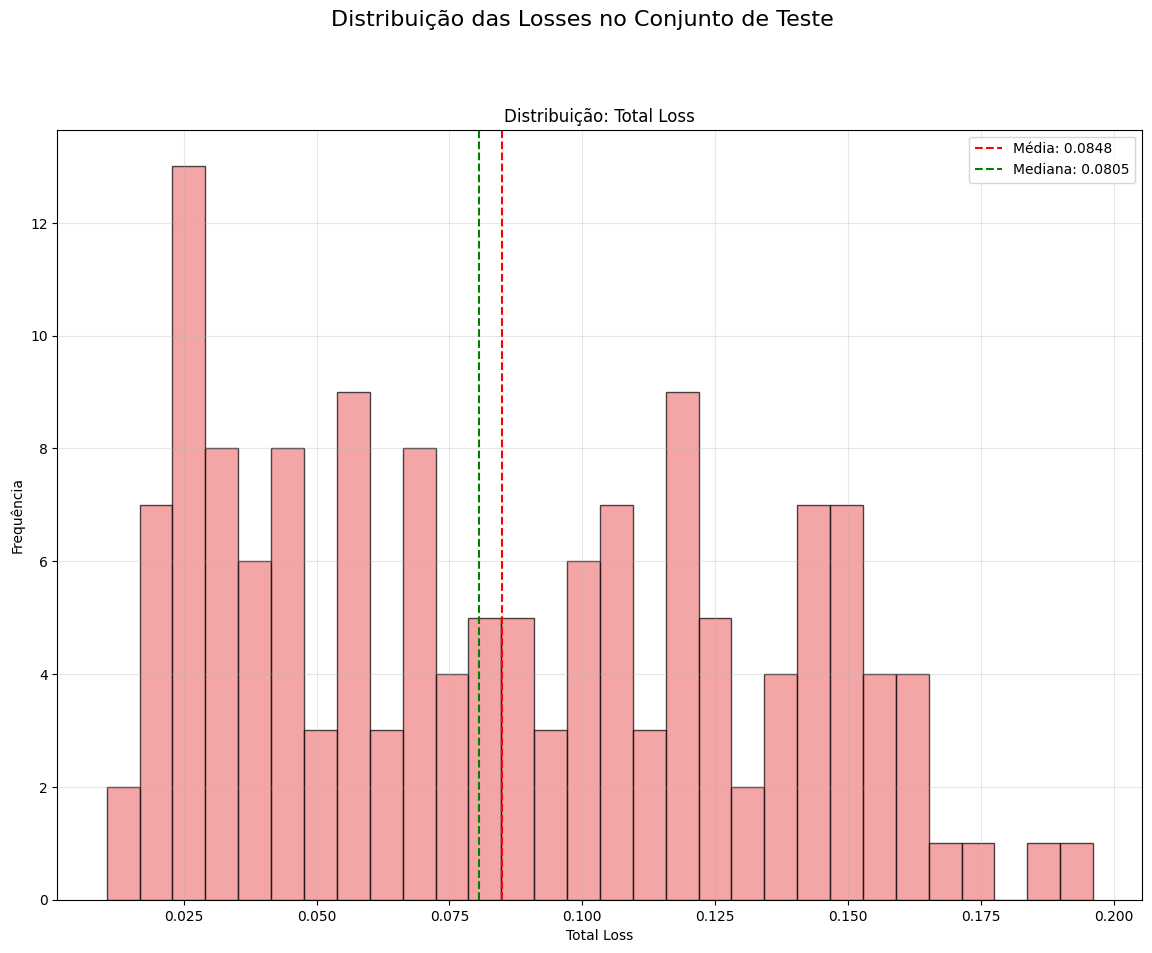

✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold1\keypoint_analysis.png


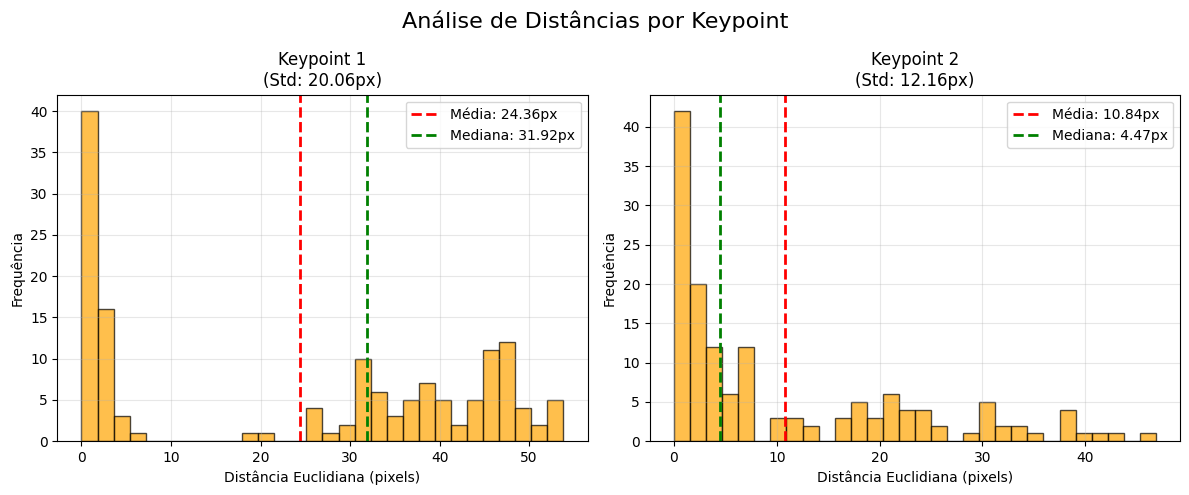


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold1\predictions_by_distance_keypoint1.png


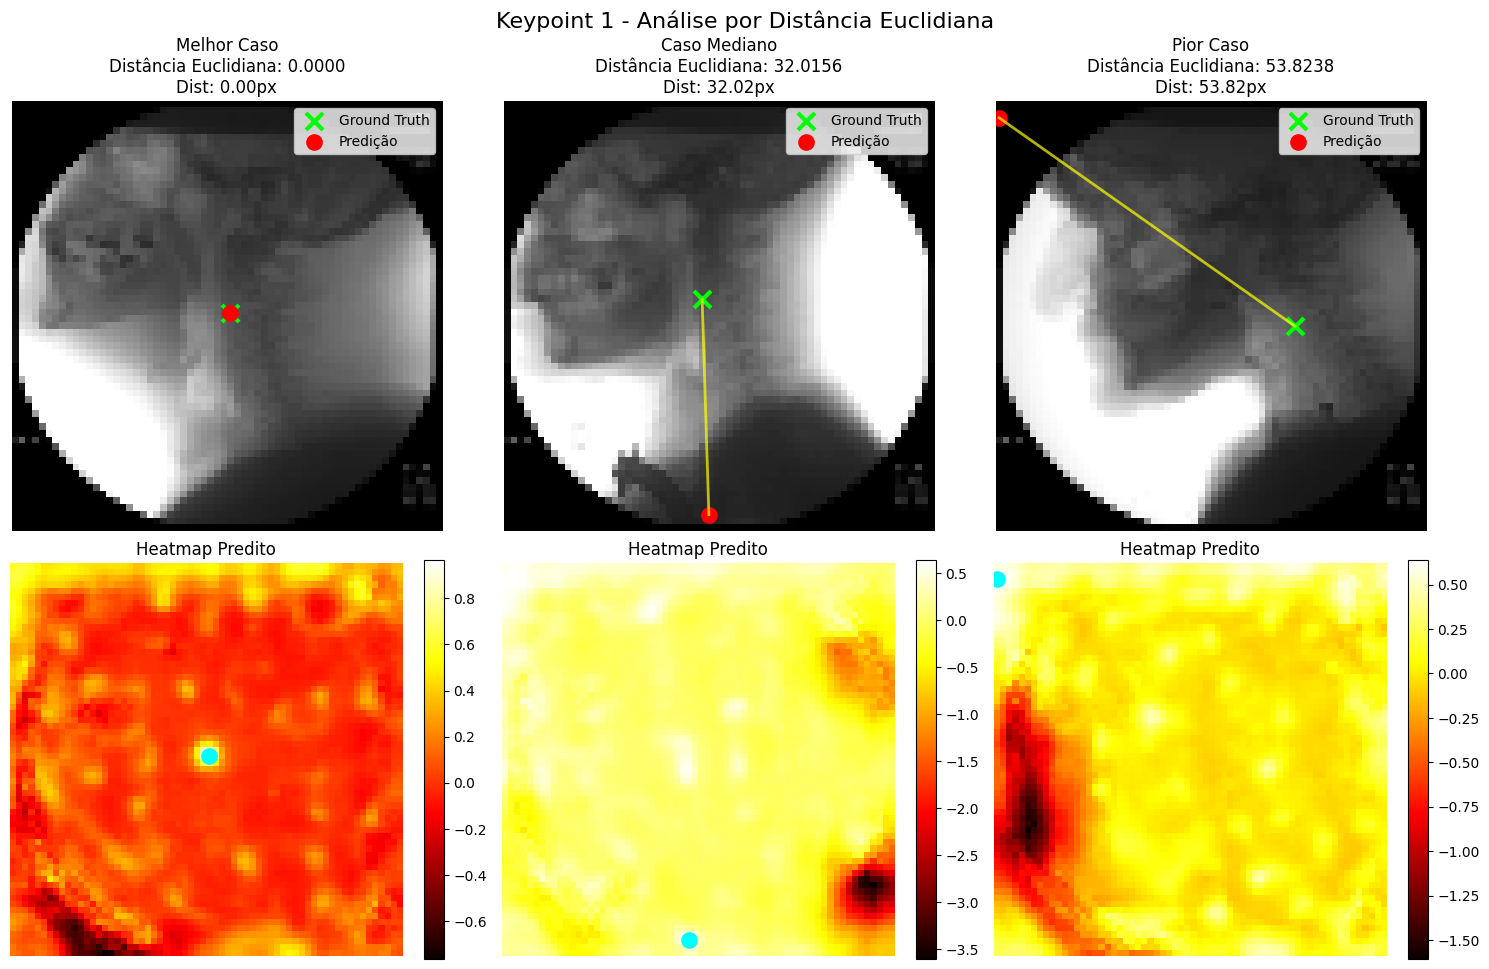


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold1\predictions_by_distance_keypoint2.png


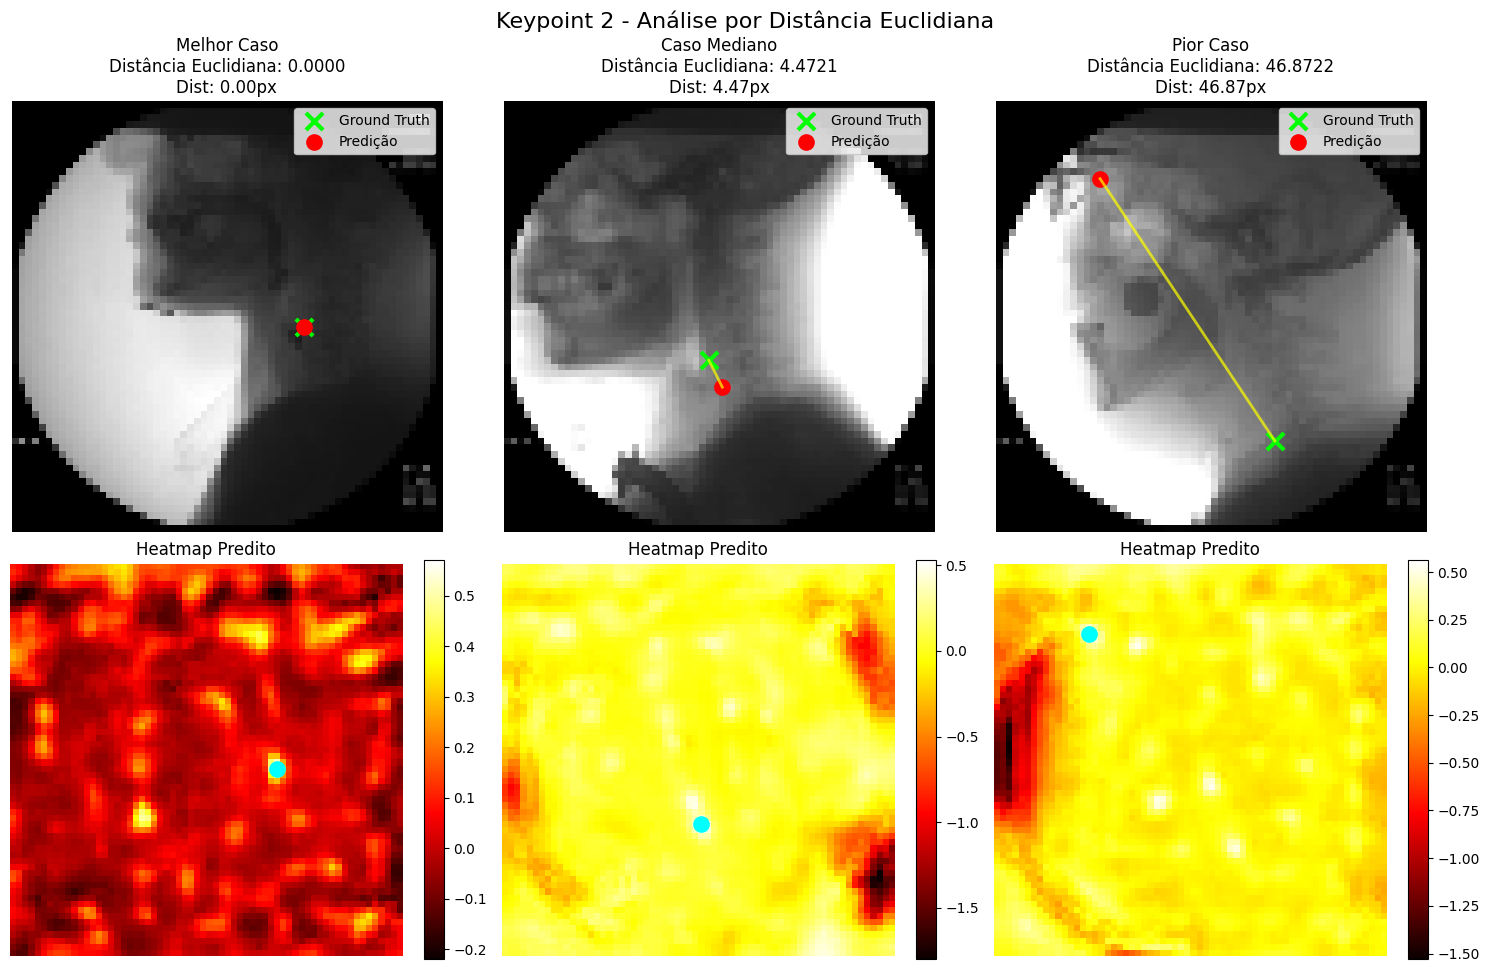


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold1\predictions_by_loss_keypoint1.png


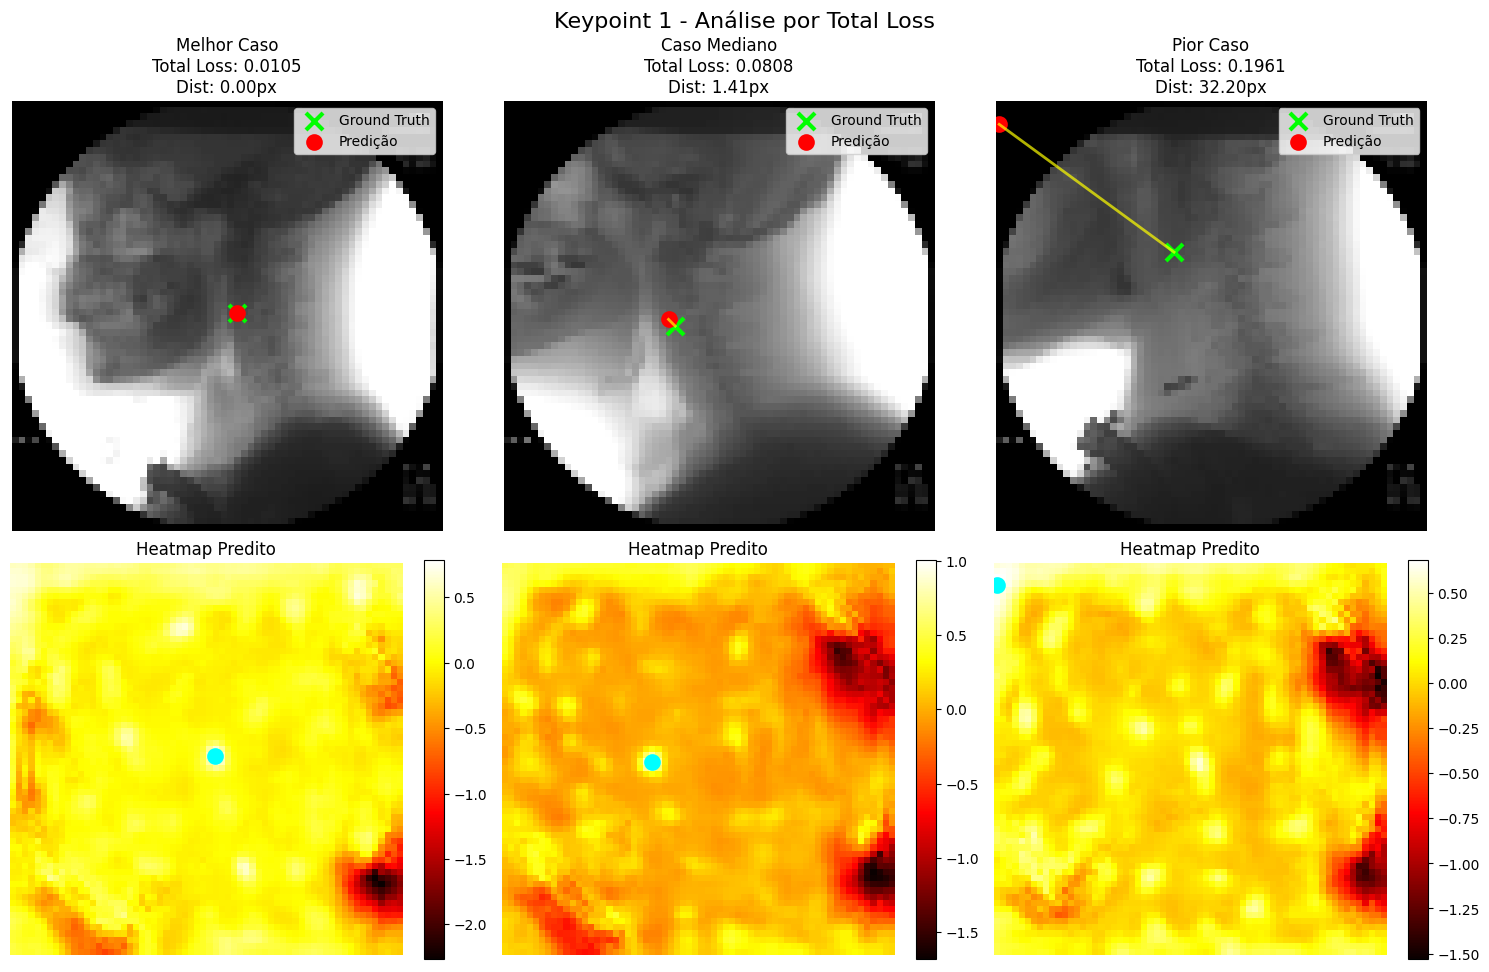


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold1\predictions_by_loss_keypoint2.png


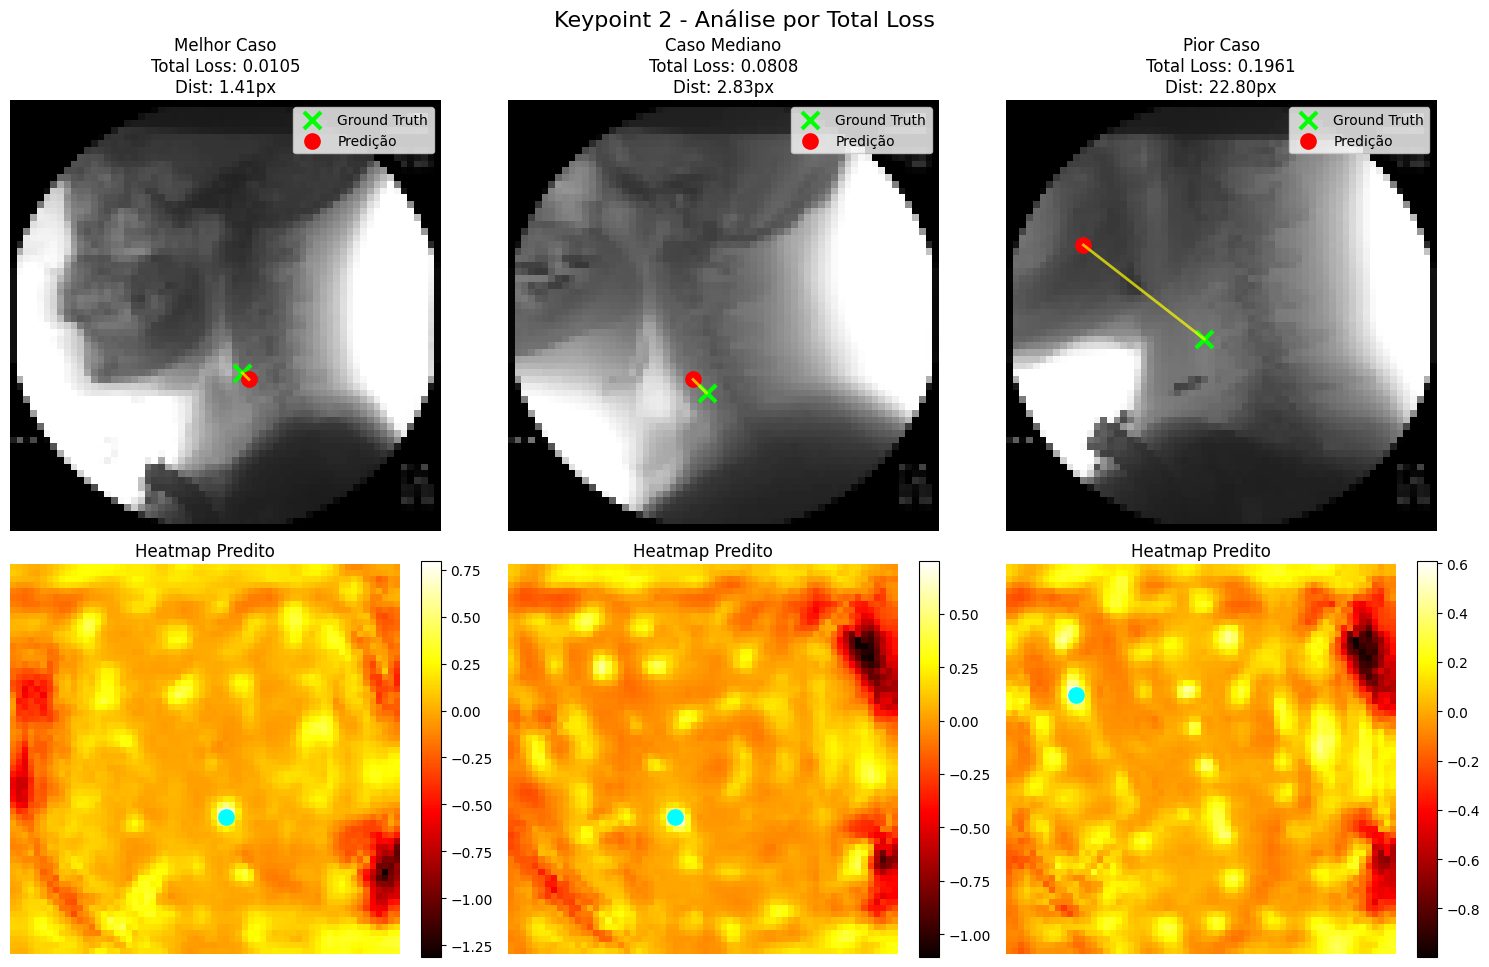

RELATÓRIO DE AVALIAÇÃO NO CONJUNTO DE TESTE

Número de amostras: 146

----------------------------------------------------------------------
LOSS TOTAL
----------------------------------------------------------------------
Média:    0.084847
Mediana:  0.080516
Std:      0.046907
Min:      0.010491
Max:      0.196147

----------------------------------------------------------------------
KEYPOINT 1 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    24.36
Mediana:  31.92
Std:      20.06
Min:      0.00
Max:      53.82
Quartis:  Q1=1.41, Q3=43.69

----------------------------------------------------------------------
KEYPOINT 2 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    10.84
Mediana:  4.47
Std:      12.16
Min:      0.00
Max:      46.87
Quartis:  Q1=1.41, Q3=19.26


✓ Relatório salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold1\evaluation_report.t

Avaliando: 100%|██████████| 146/146 [00:30<00:00,  4.80it/s]



GERANDO VISUALIZAÇÕES
✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold2\loss_distributions.png


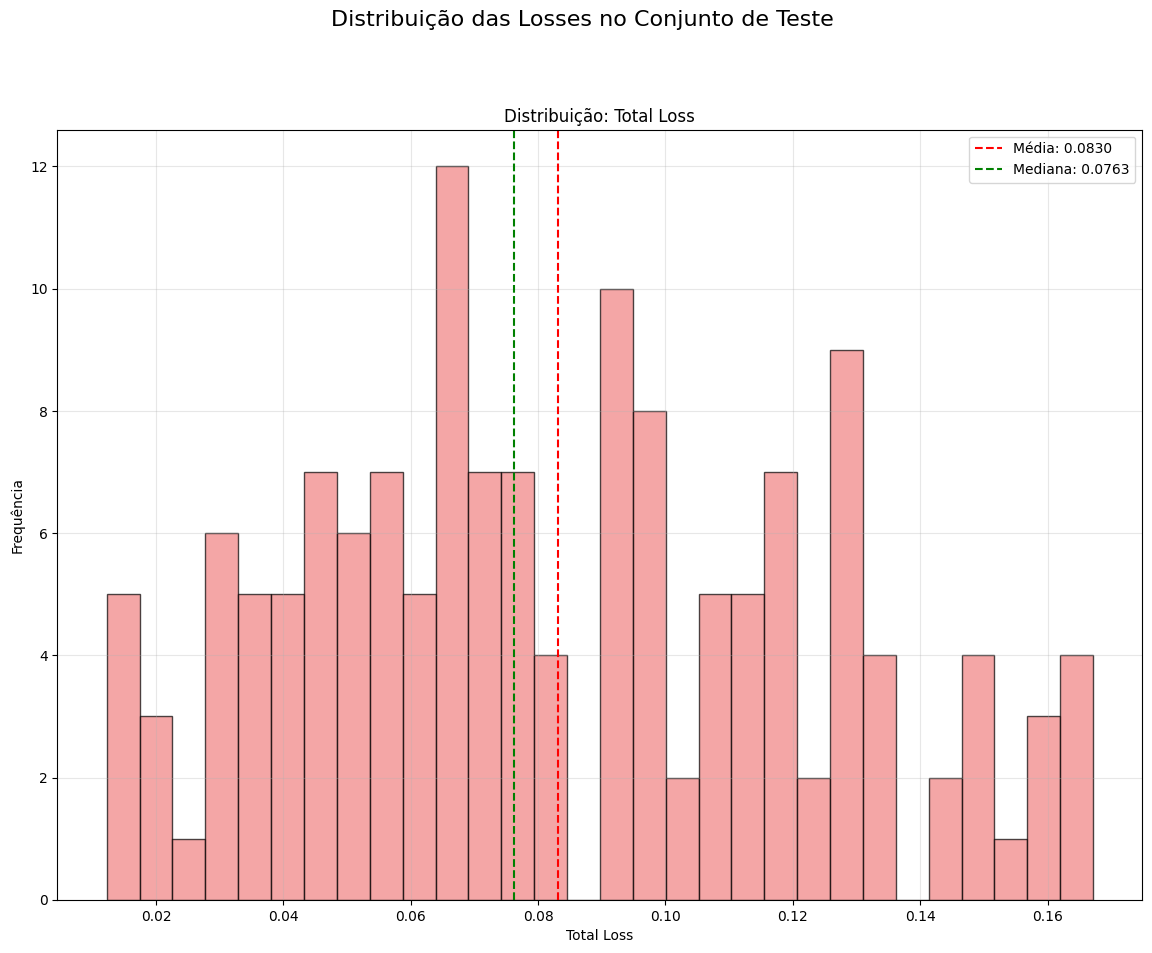

✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold2\keypoint_analysis.png


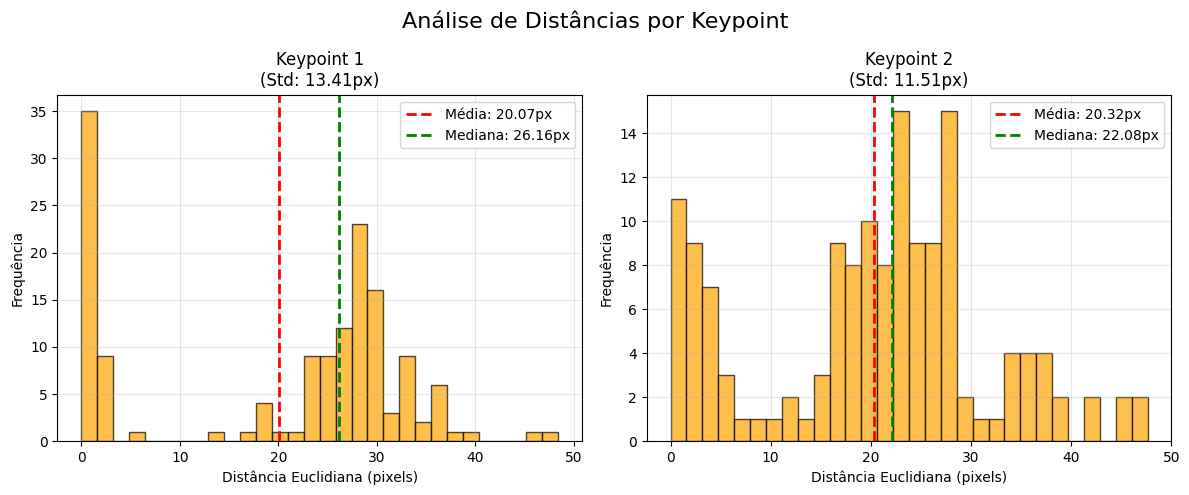


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold2\predictions_by_distance_keypoint1.png


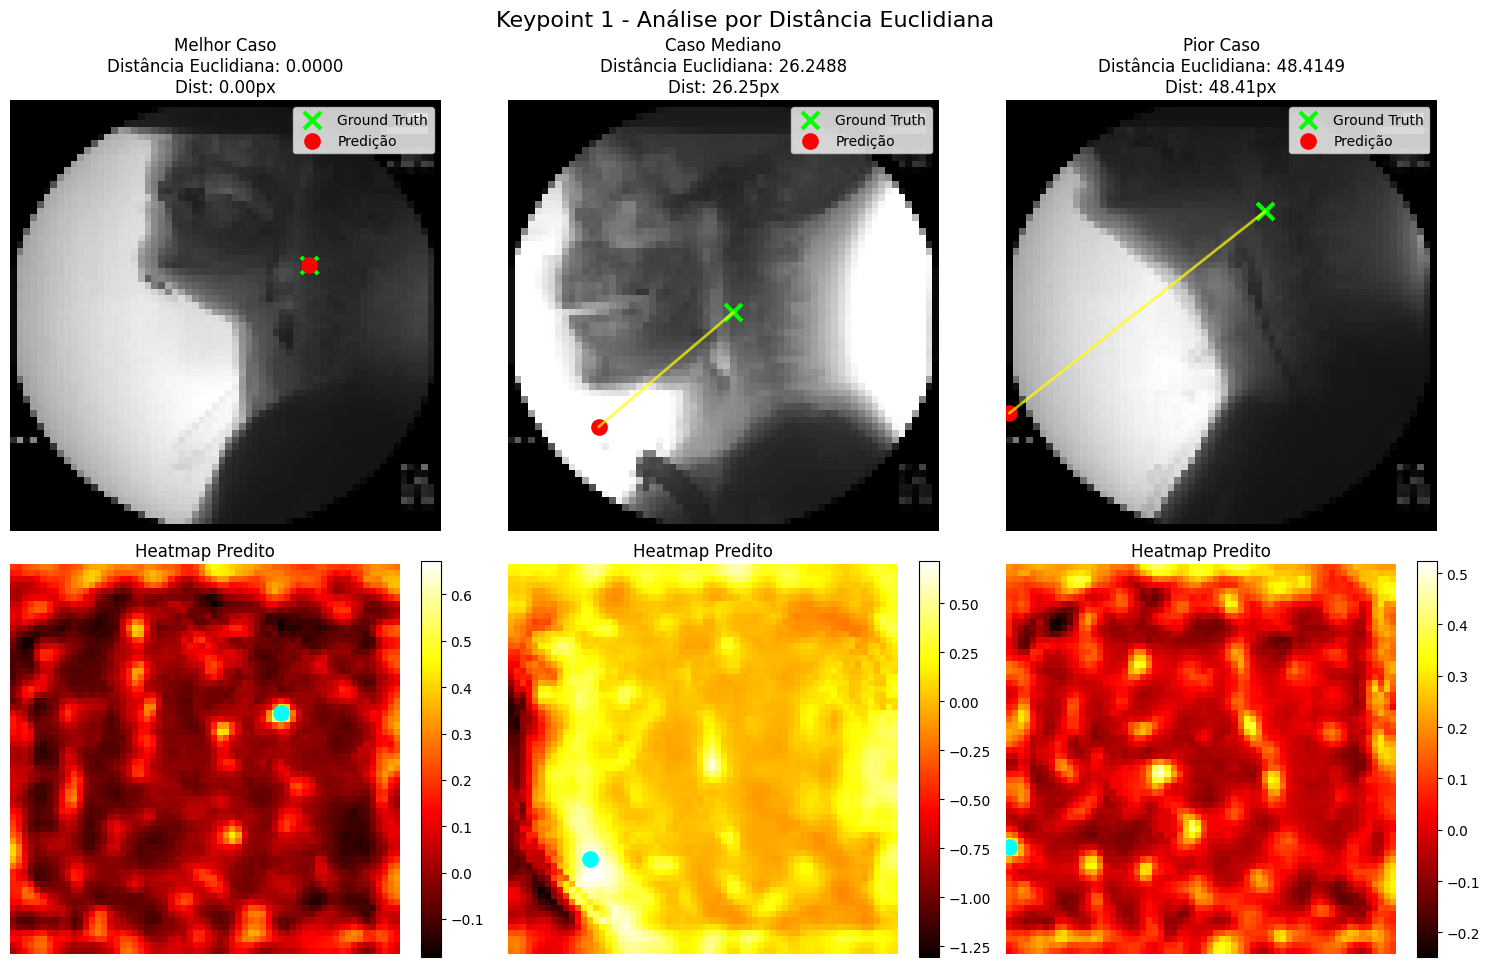


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold2\predictions_by_distance_keypoint2.png


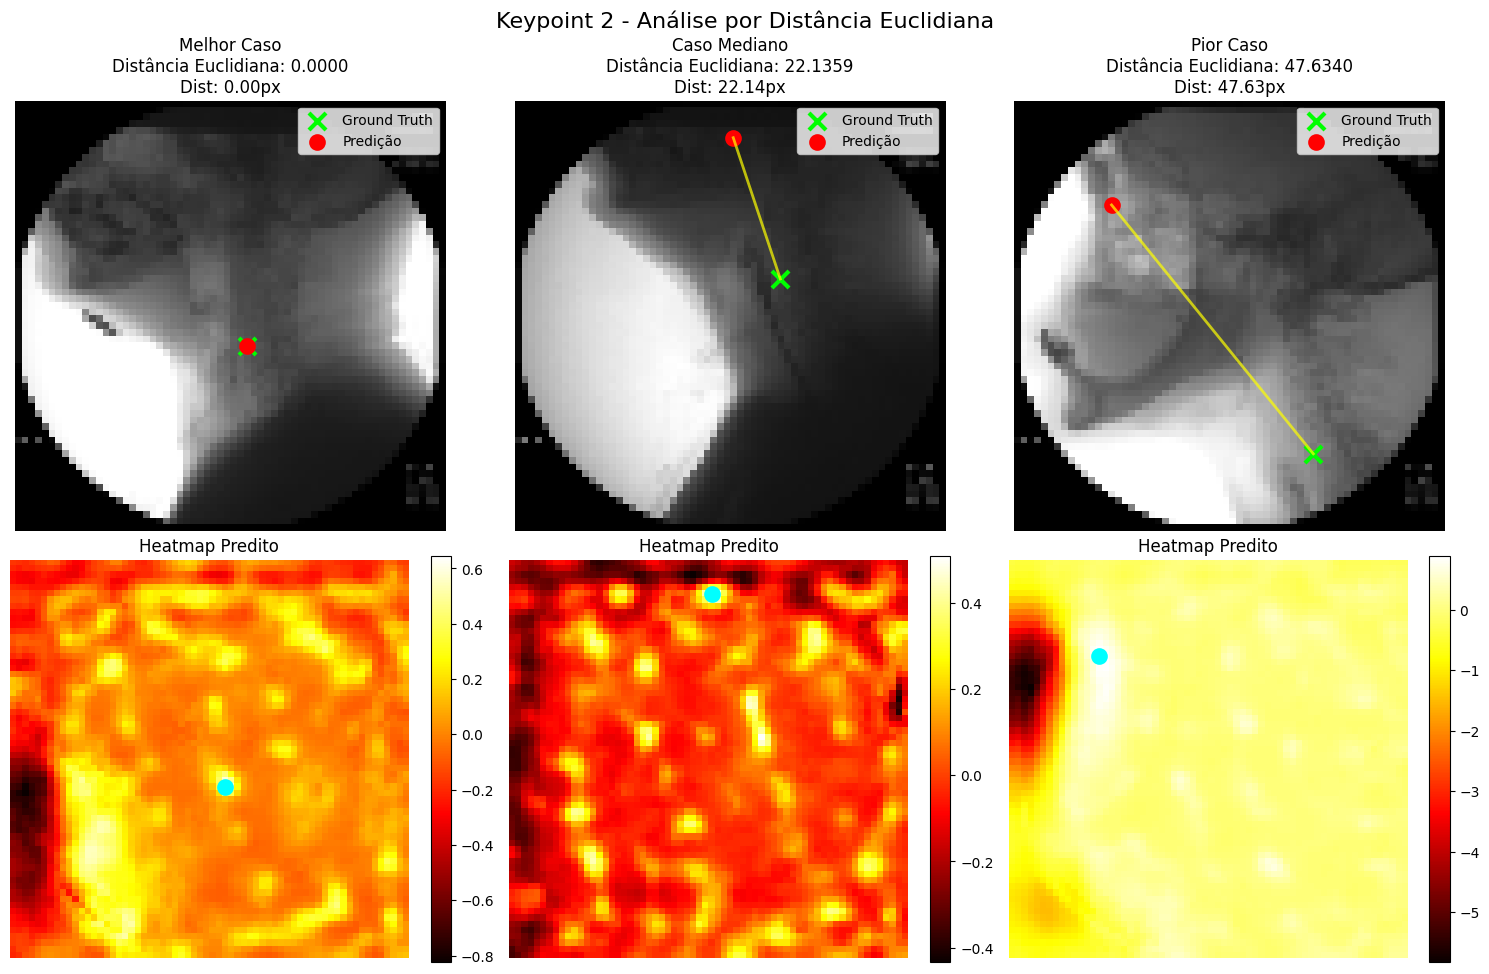


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold2\predictions_by_loss_keypoint1.png


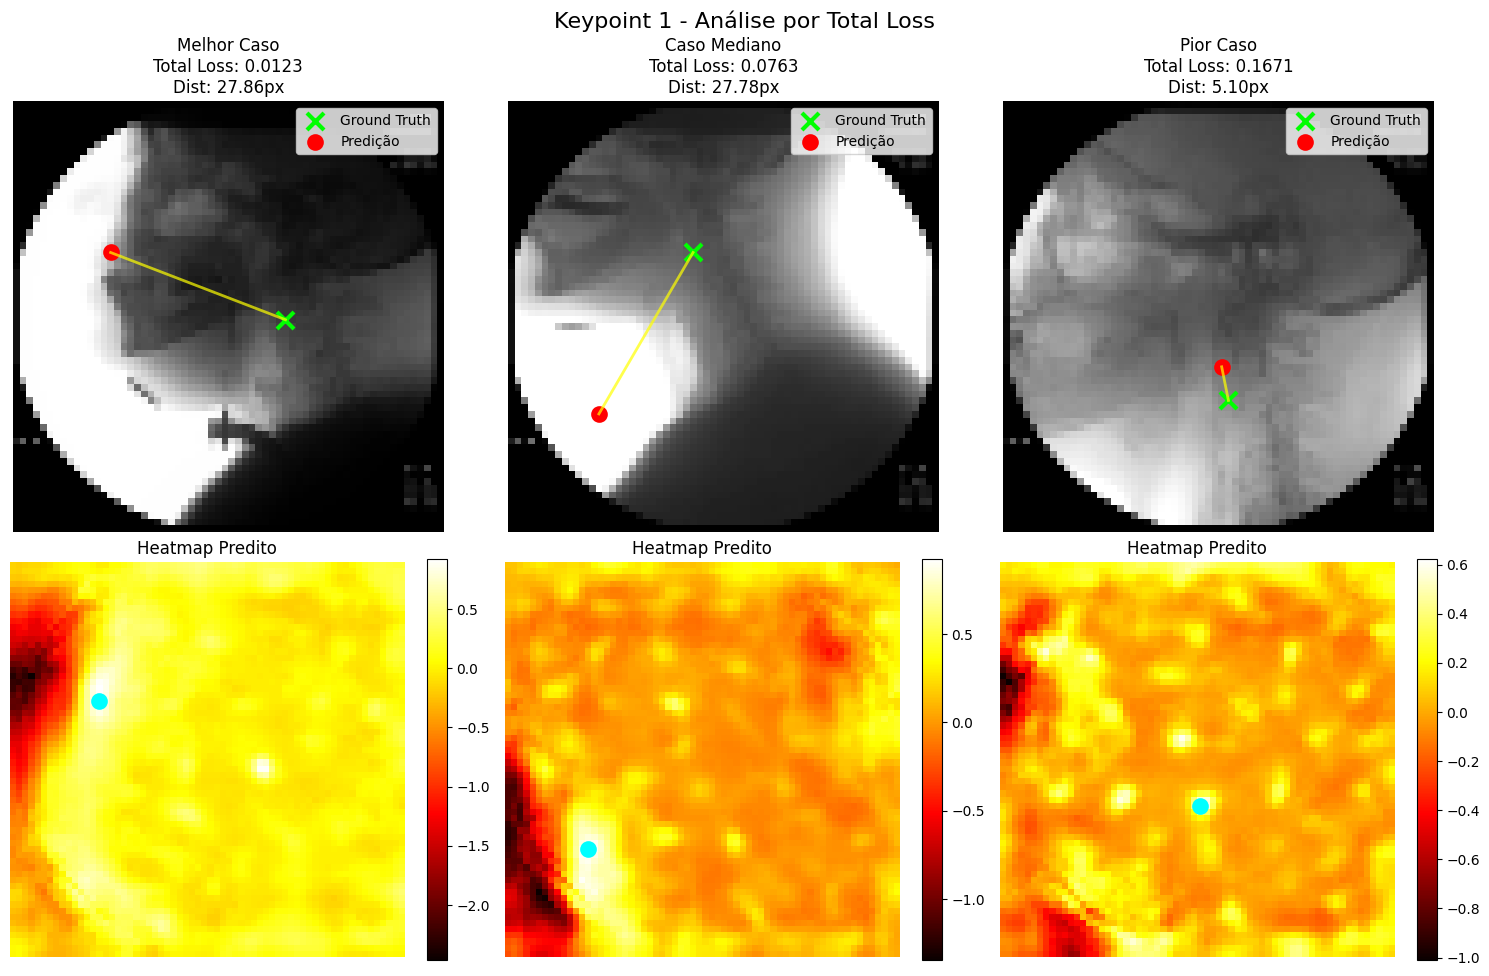


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold2\predictions_by_loss_keypoint2.png


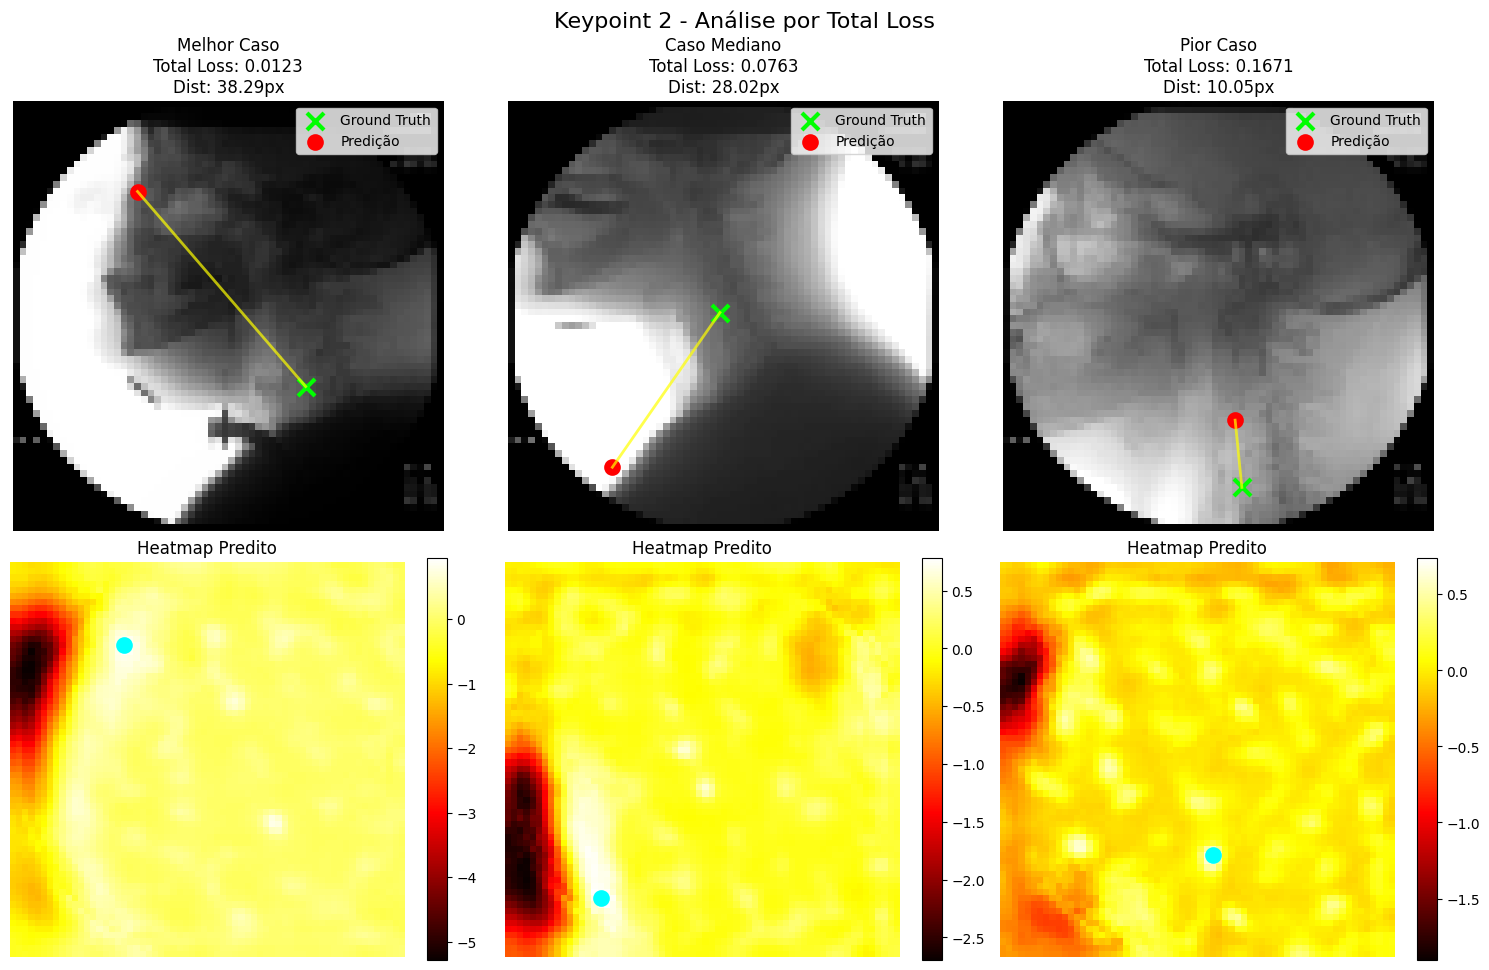

RELATÓRIO DE AVALIAÇÃO NO CONJUNTO DE TESTE

Número de amostras: 146

----------------------------------------------------------------------
LOSS TOTAL
----------------------------------------------------------------------
Média:    0.083045
Mediana:  0.076264
Std:      0.039801
Min:      0.012253
Max:      0.167147

----------------------------------------------------------------------
KEYPOINT 1 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    20.07
Mediana:  26.16
Std:      13.41
Min:      0.00
Max:      48.41
Quartis:  Q1=2.00, Q3=29.15

----------------------------------------------------------------------
KEYPOINT 2 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    20.32
Mediana:  22.08
Std:      11.51
Min:      0.00
Max:      47.63
Quartis:  Q1=14.61, Q3=27.01


✓ Relatório salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold2\evaluation_report

Avaliando: 100%|██████████| 146/146 [00:30<00:00,  4.86it/s]



GERANDO VISUALIZAÇÕES
✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold3\loss_distributions.png


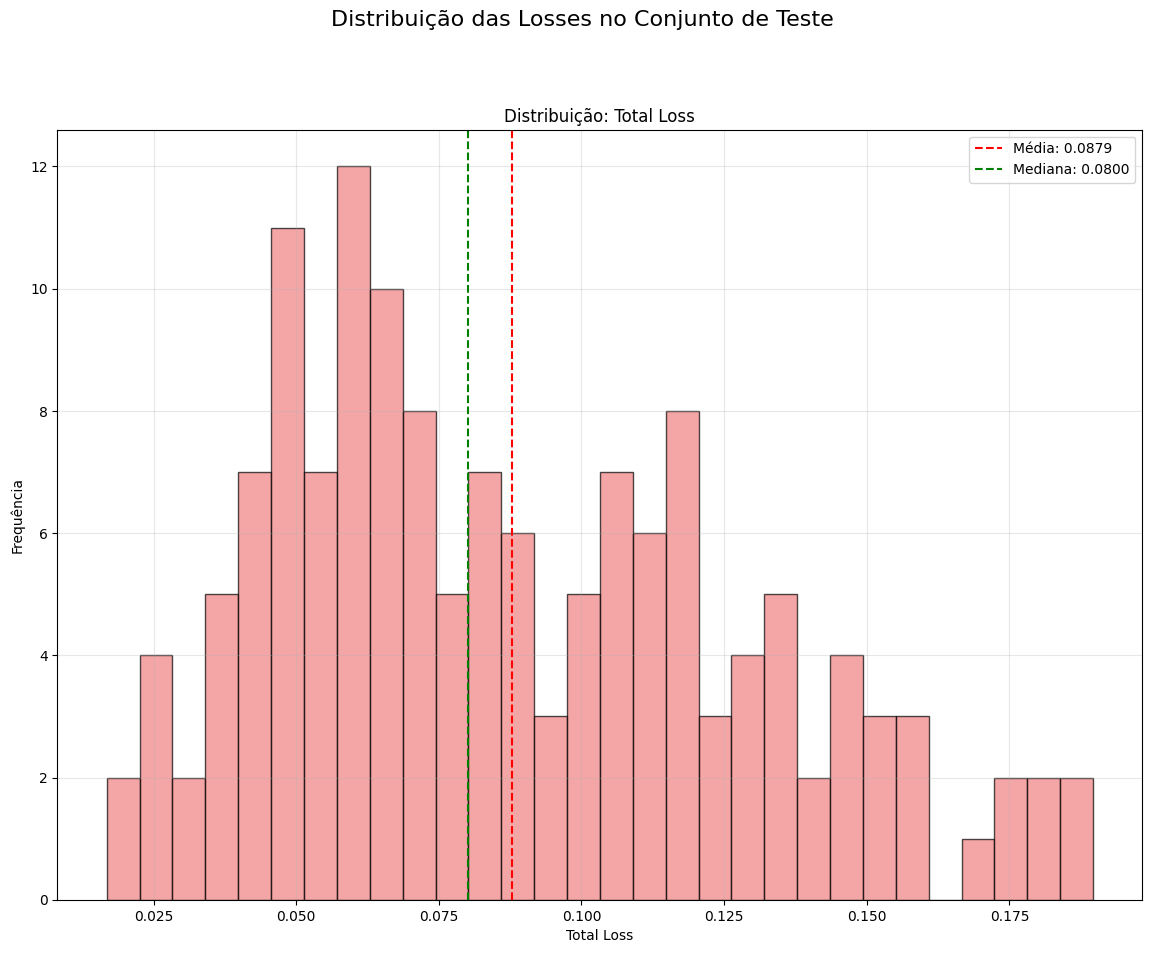

✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold3\keypoint_analysis.png


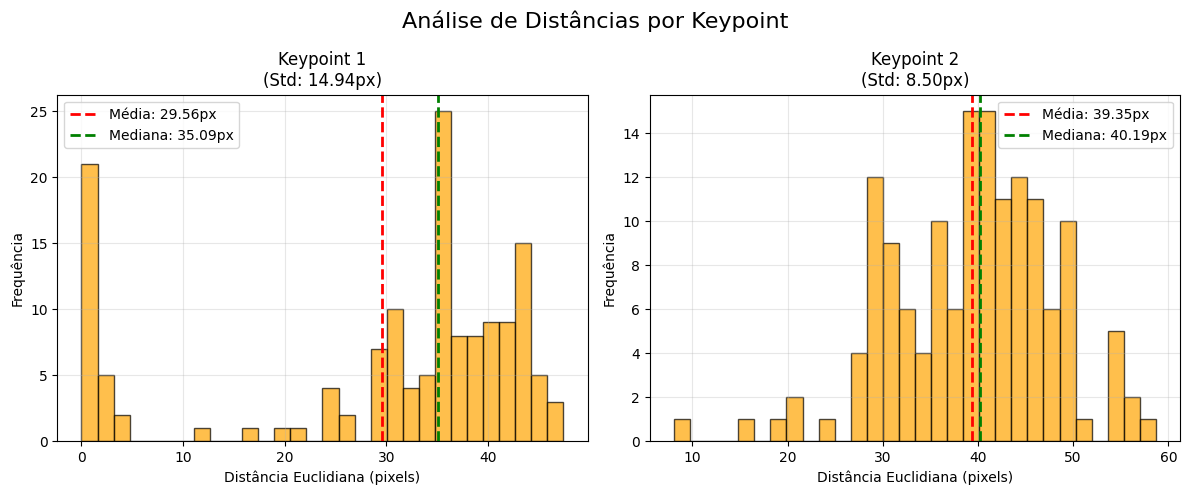


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold3\predictions_by_distance_keypoint1.png


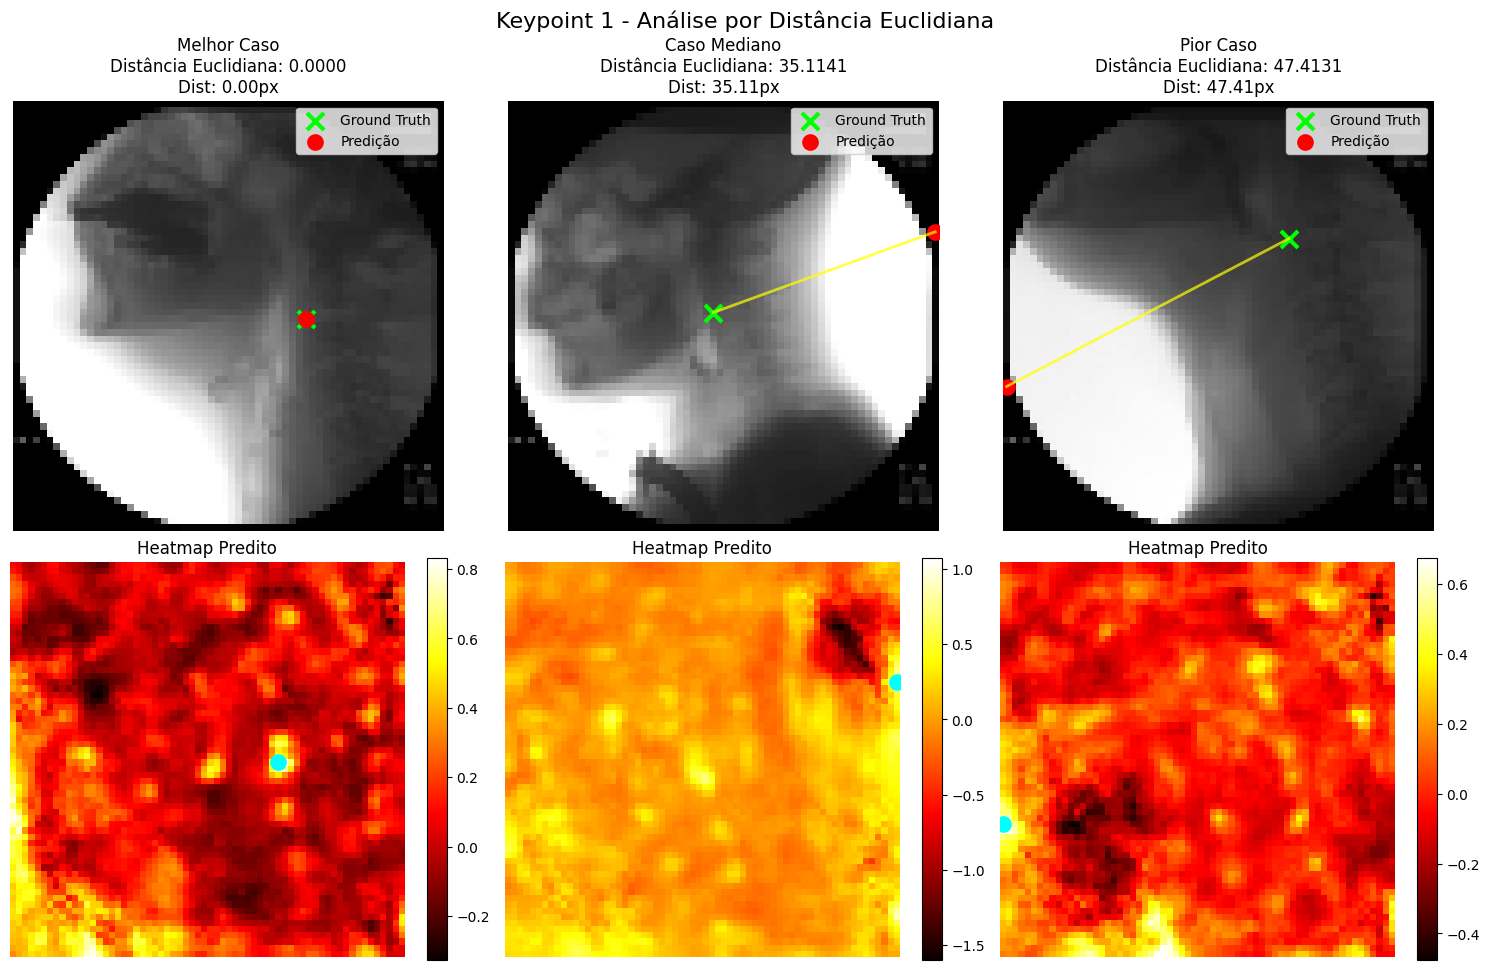


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold3\predictions_by_distance_keypoint2.png


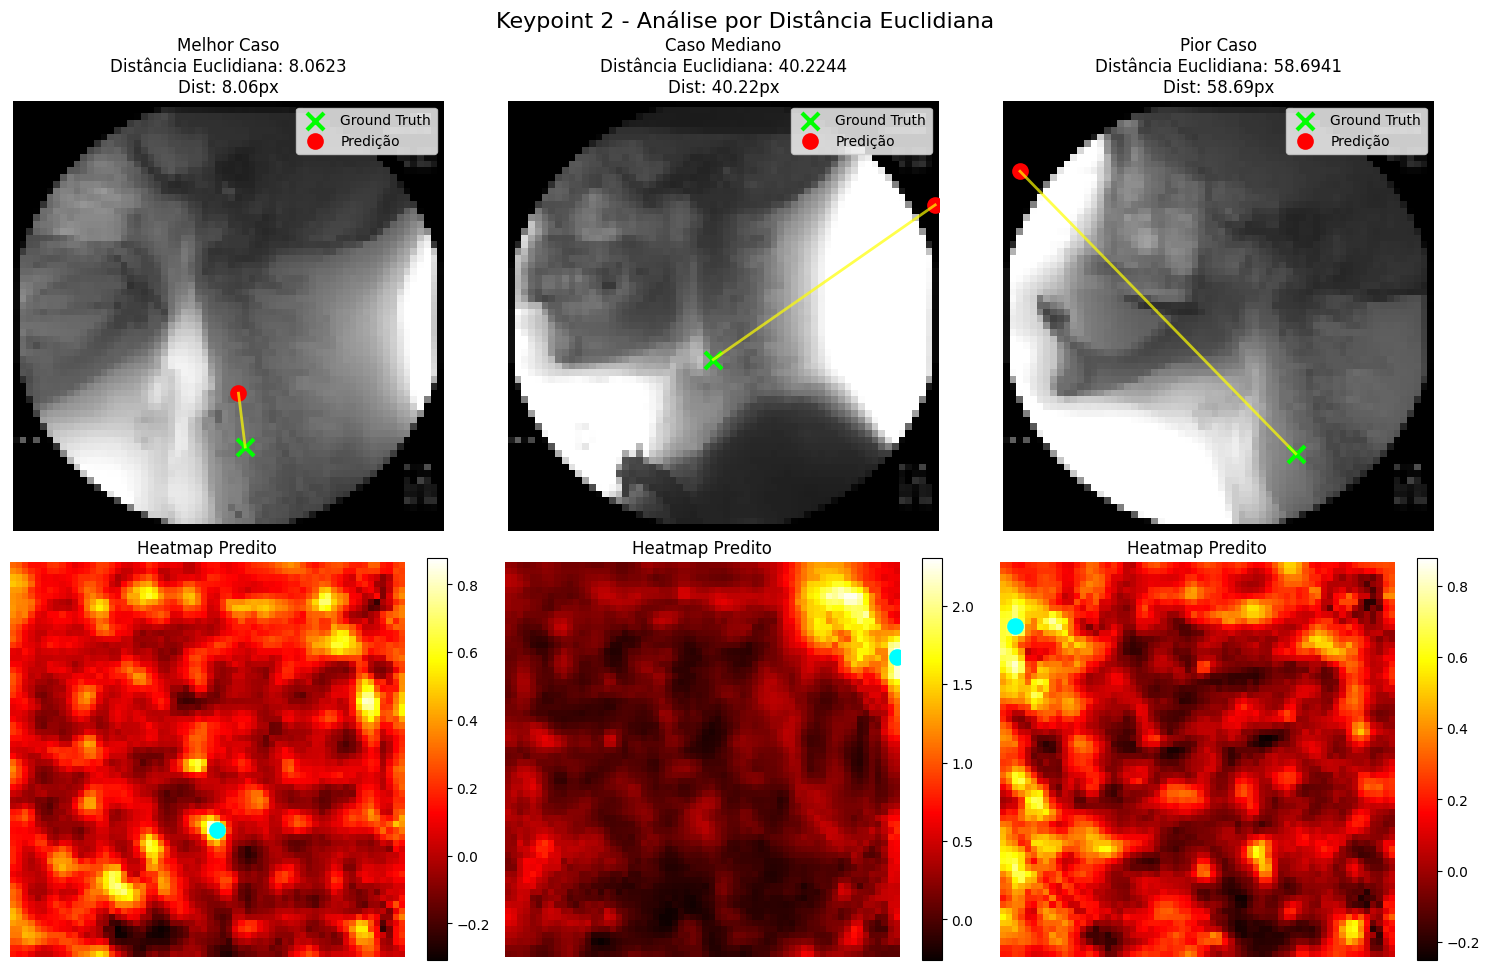


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold3\predictions_by_loss_keypoint1.png


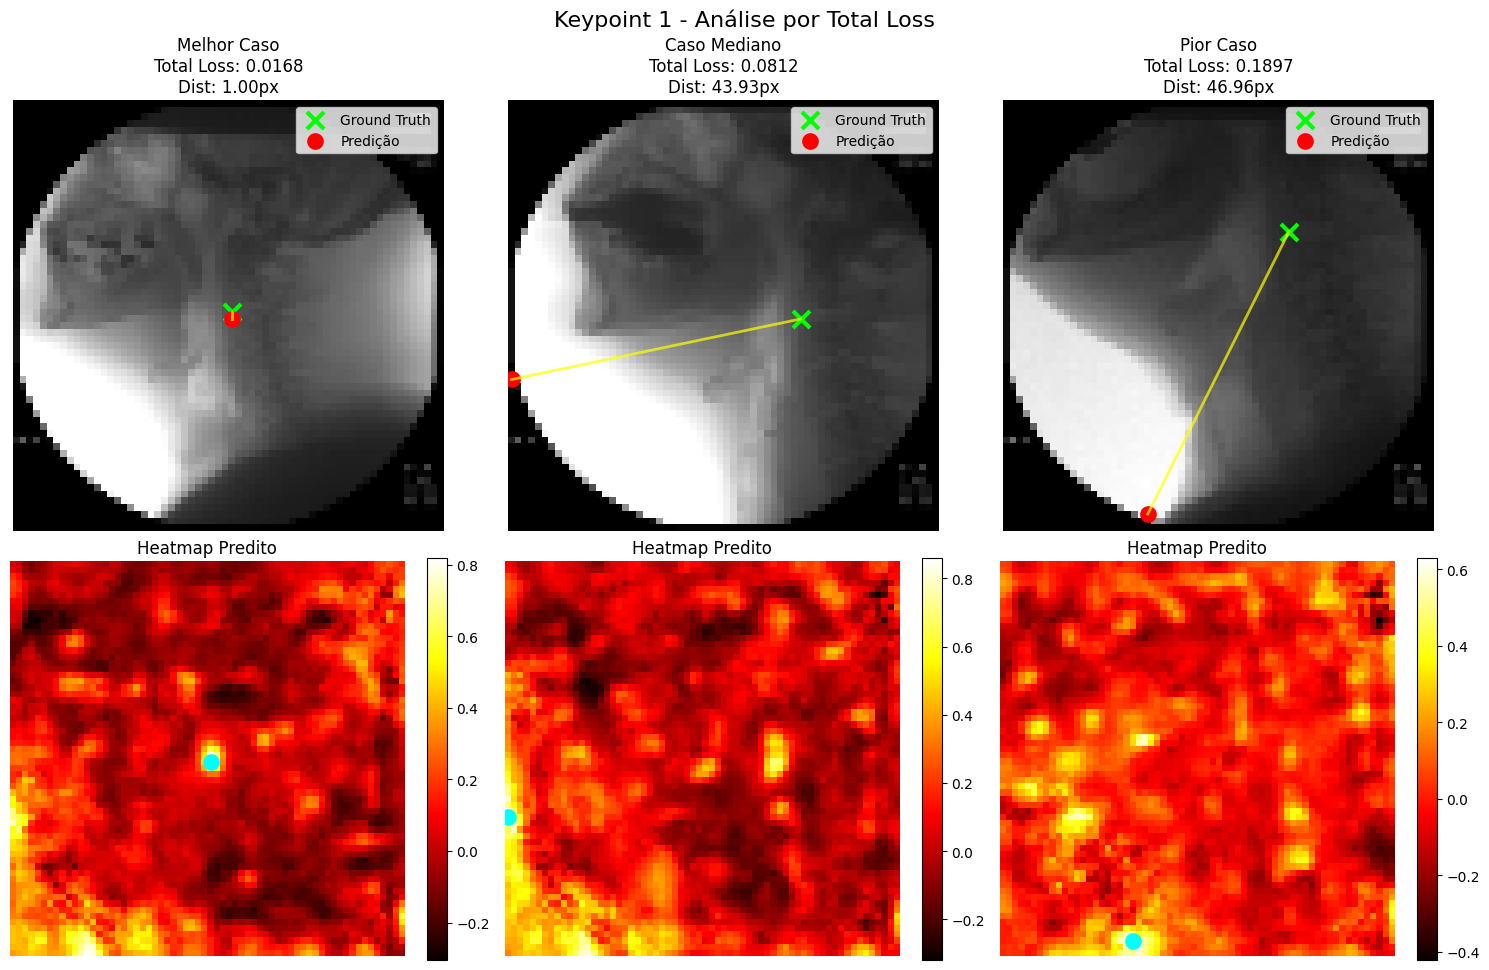


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold3\predictions_by_loss_keypoint2.png


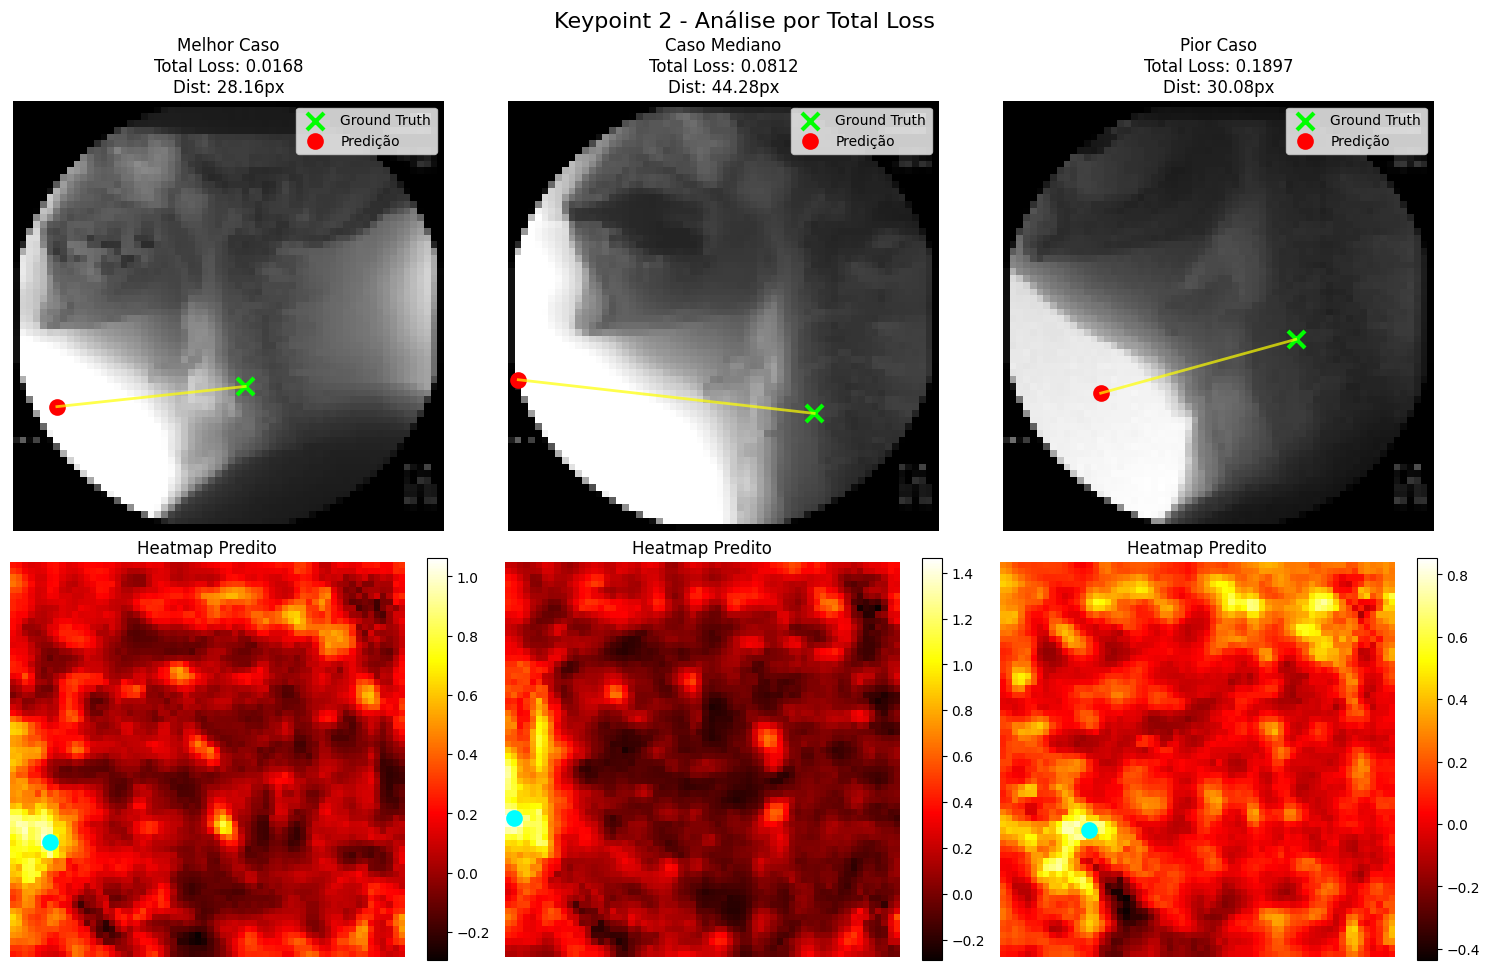

RELATÓRIO DE AVALIAÇÃO NO CONJUNTO DE TESTE

Número de amostras: 146

----------------------------------------------------------------------
LOSS TOTAL
----------------------------------------------------------------------
Média:    0.087898
Mediana:  0.080027
Std:      0.040420
Min:      0.016791
Max:      0.189670

----------------------------------------------------------------------
KEYPOINT 1 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    29.56
Mediana:  35.09
Std:      14.94
Min:      0.00
Max:      47.41
Quartis:  Q1=25.48, Q3=39.84

----------------------------------------------------------------------
KEYPOINT 2 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    39.35
Mediana:  40.19
Std:      8.50
Min:      8.06
Max:      58.69
Quartis:  Q1=33.11, Q3=45.08


✓ Relatório salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold3\evaluation_report

Avaliando: 100%|██████████| 146/146 [00:30<00:00,  4.84it/s]



GERANDO VISUALIZAÇÕES
✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold4\loss_distributions.png


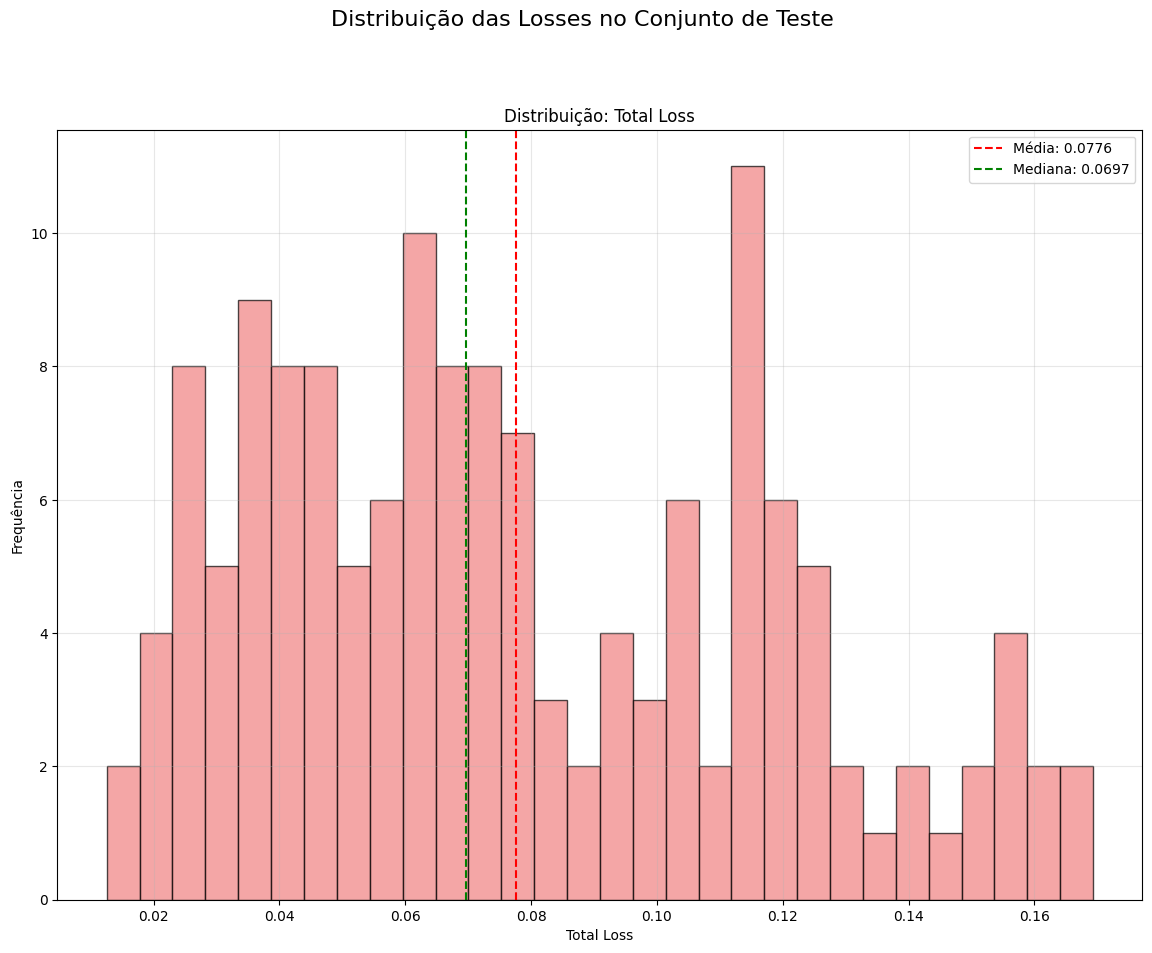

✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold4\keypoint_analysis.png


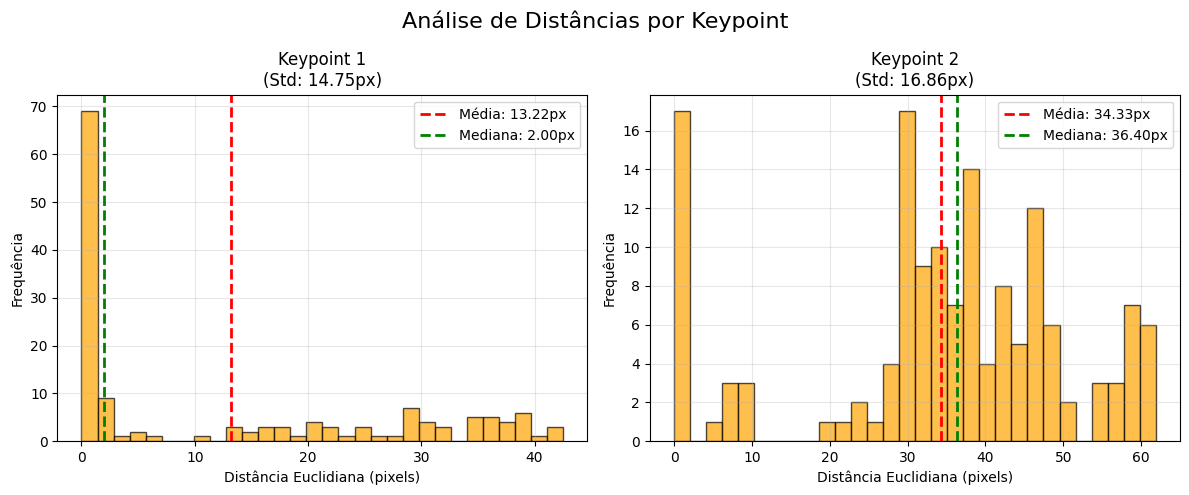


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold4\predictions_by_distance_keypoint1.png


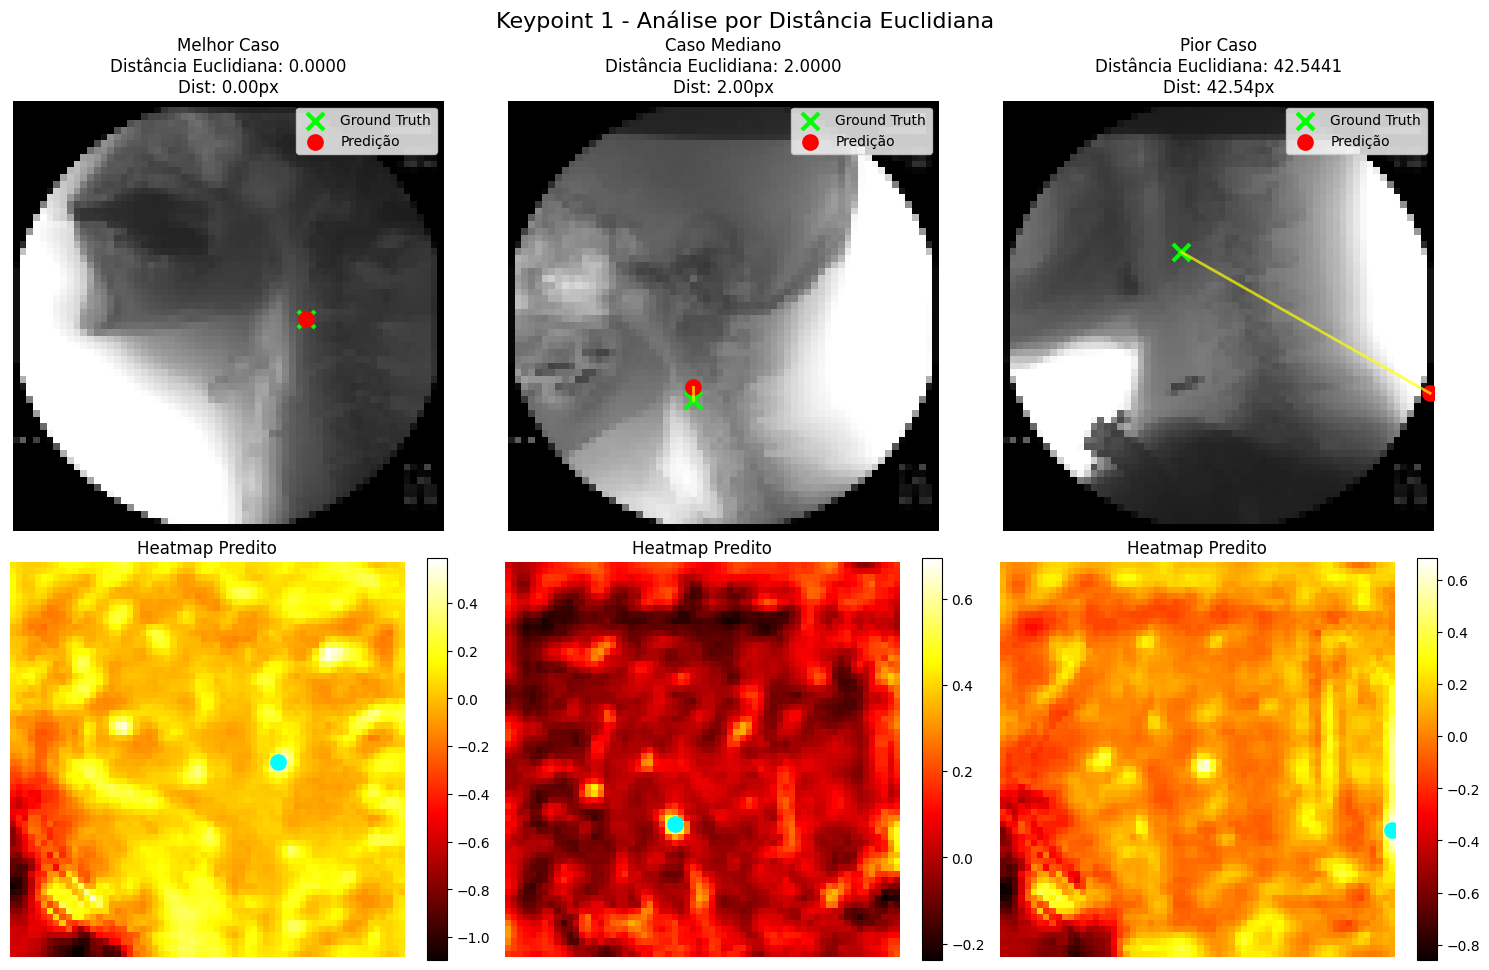


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold4\predictions_by_distance_keypoint2.png


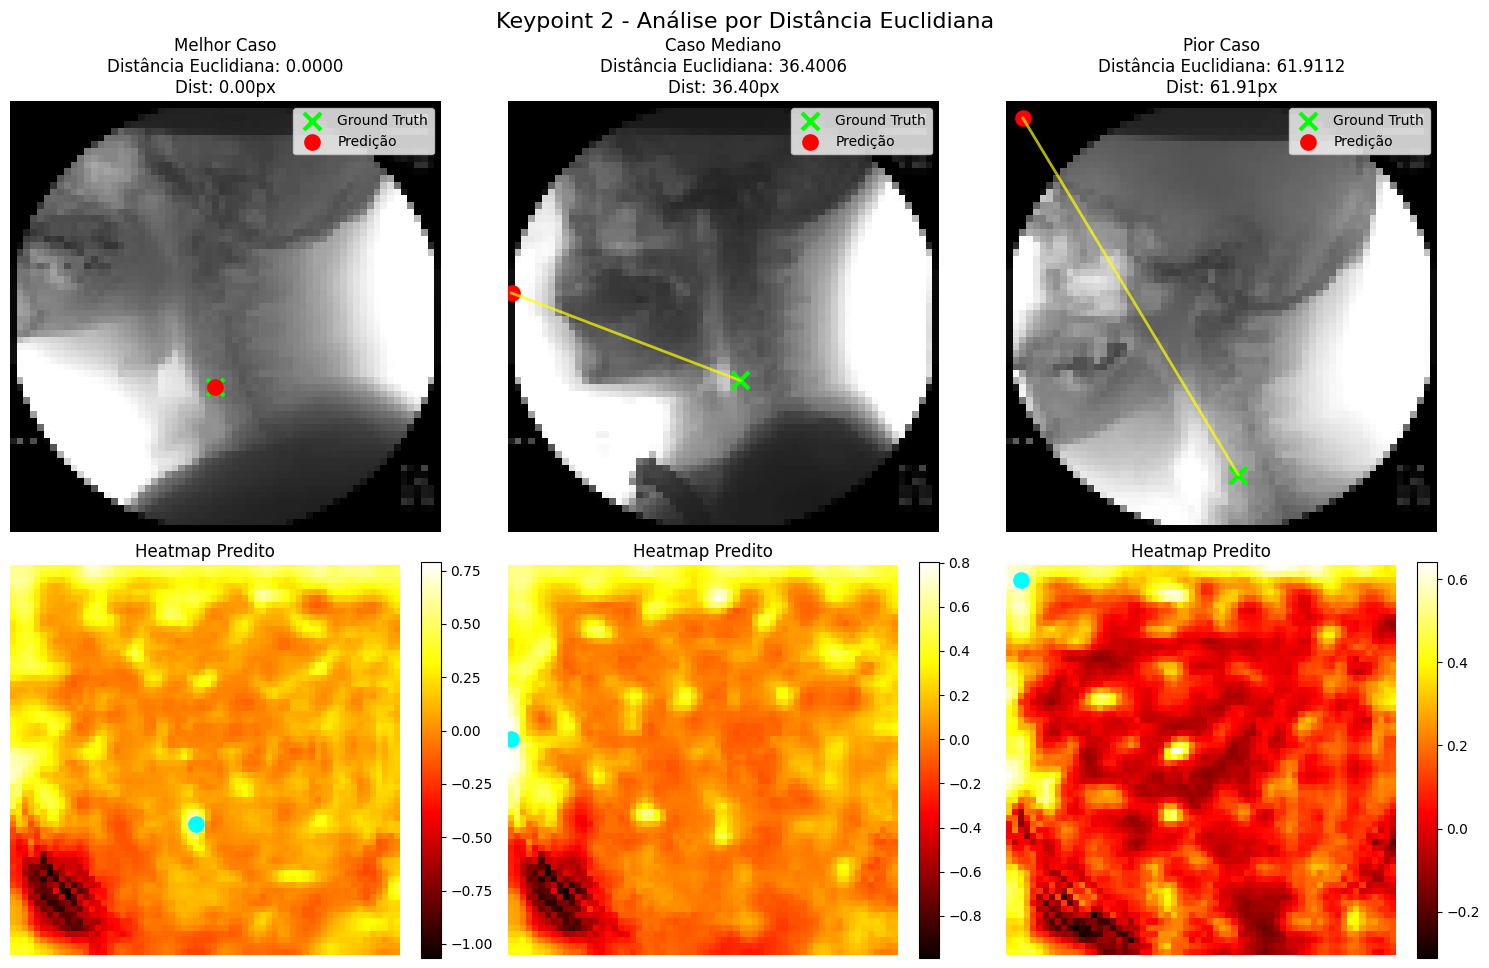


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold4\predictions_by_loss_keypoint1.png


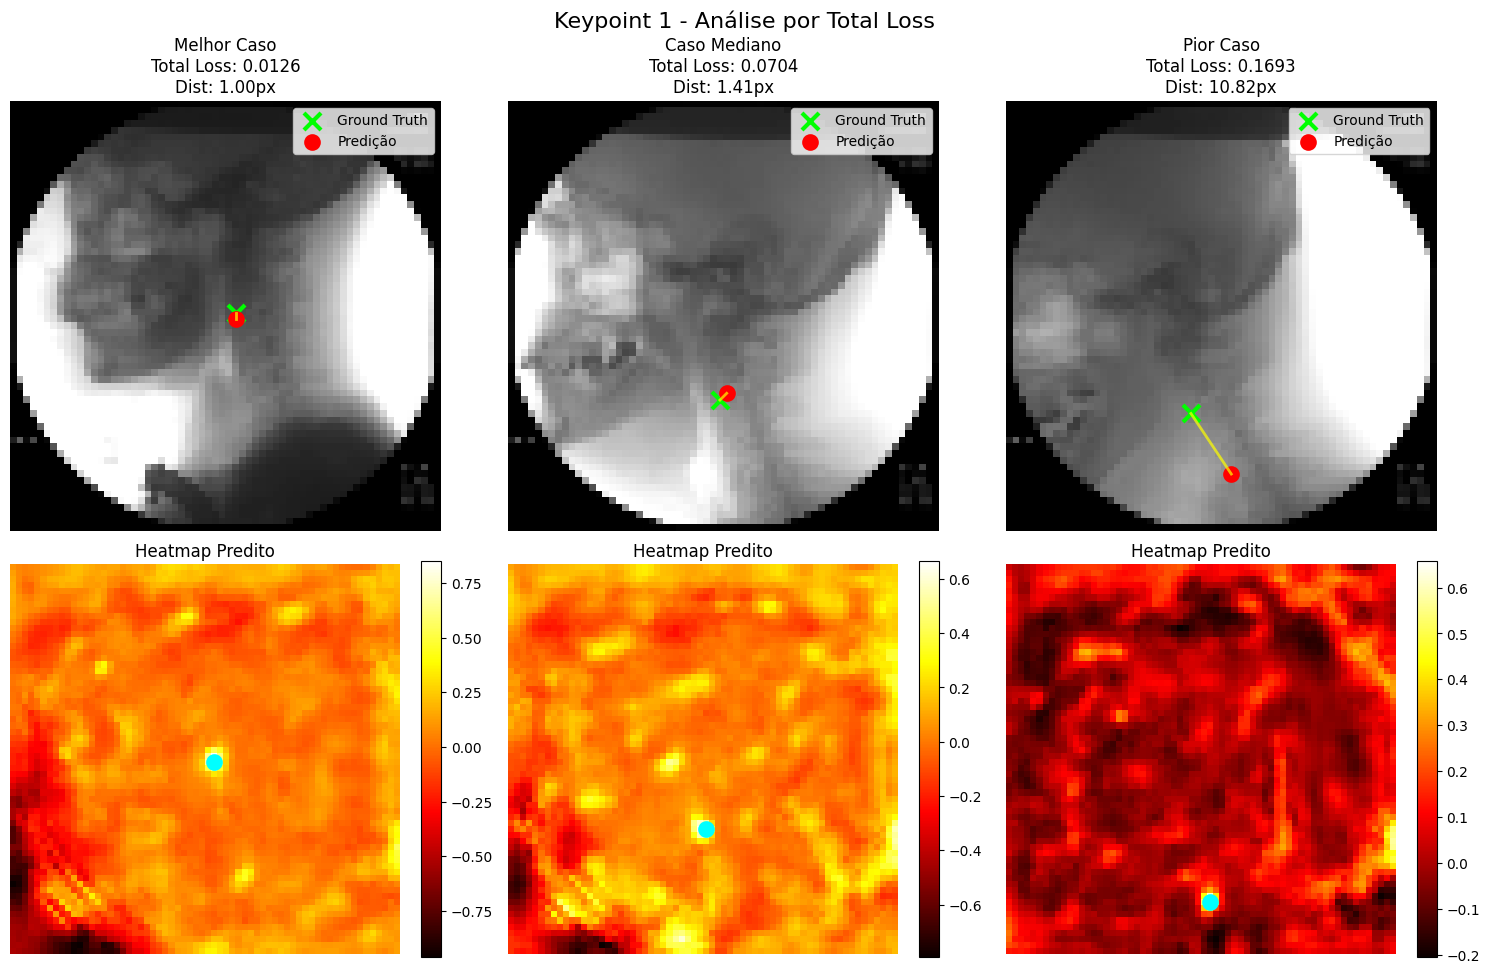


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold4\predictions_by_loss_keypoint2.png


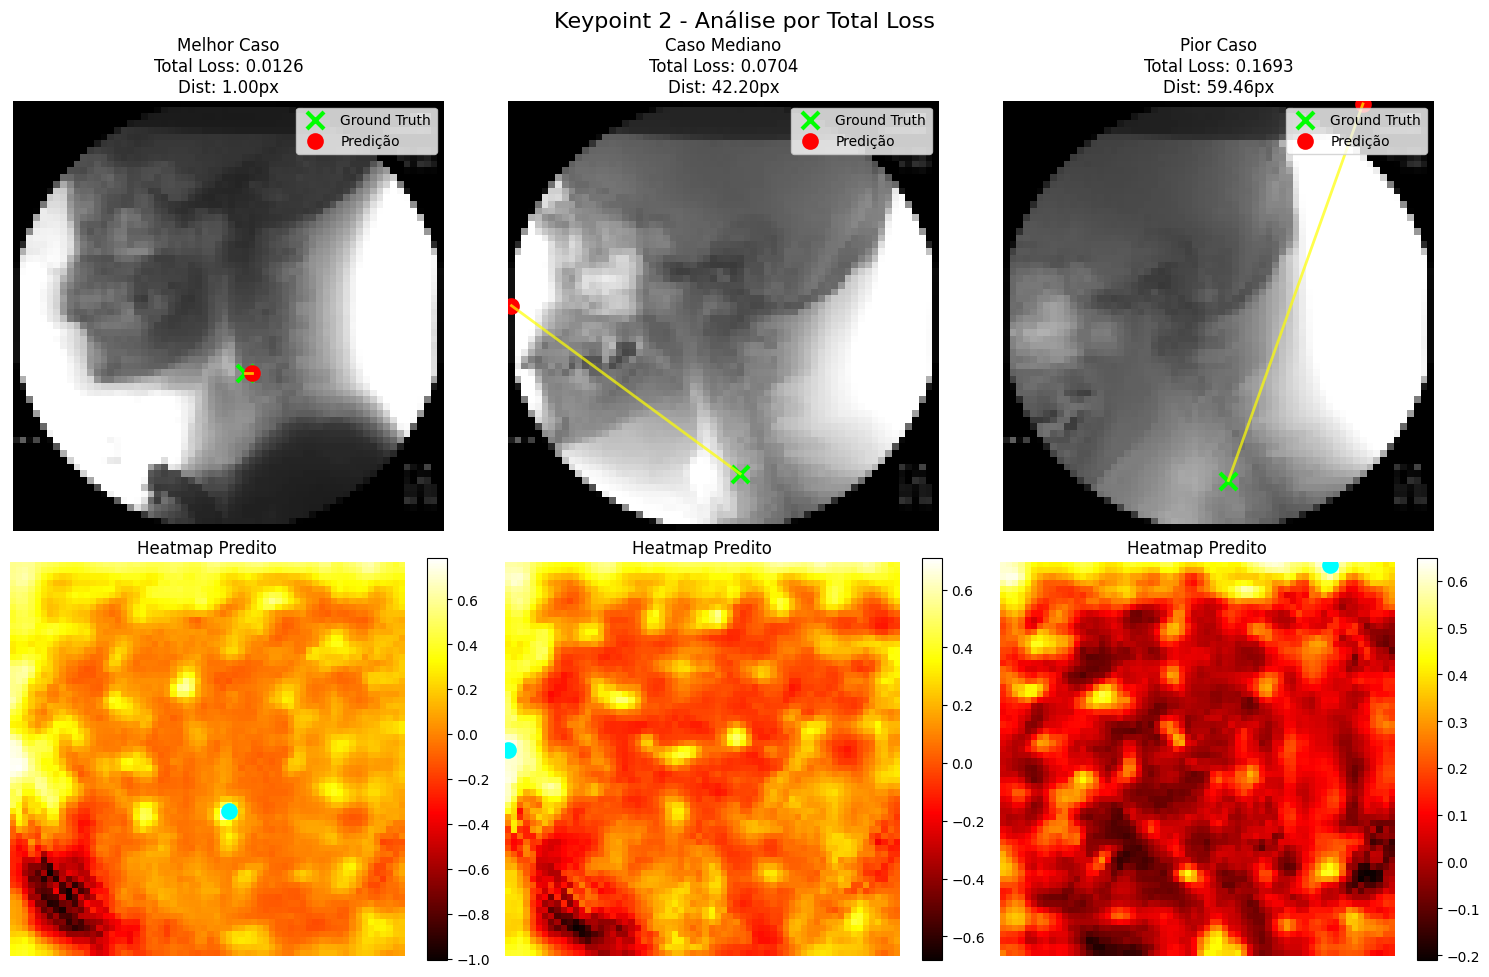

RELATÓRIO DE AVALIAÇÃO NO CONJUNTO DE TESTE

Número de amostras: 146

----------------------------------------------------------------------
LOSS TOTAL
----------------------------------------------------------------------
Média:    0.077551
Mediana:  0.069671
Std:      0.039790
Min:      0.012562
Max:      0.169332

----------------------------------------------------------------------
KEYPOINT 1 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    13.22
Mediana:  2.00
Std:      14.75
Min:      0.00
Max:      42.54
Quartis:  Q1=1.00, Q3=28.74

----------------------------------------------------------------------
KEYPOINT 2 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    34.33
Mediana:  36.40
Std:      16.86
Min:      0.00
Max:      61.91
Quartis:  Q1=29.44, Q3=46.14


✓ Relatório salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold4\evaluation_report.

Avaliando: 100%|██████████| 146/146 [00:30<00:00,  4.82it/s]



GERANDO VISUALIZAÇÕES
✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold5\loss_distributions.png


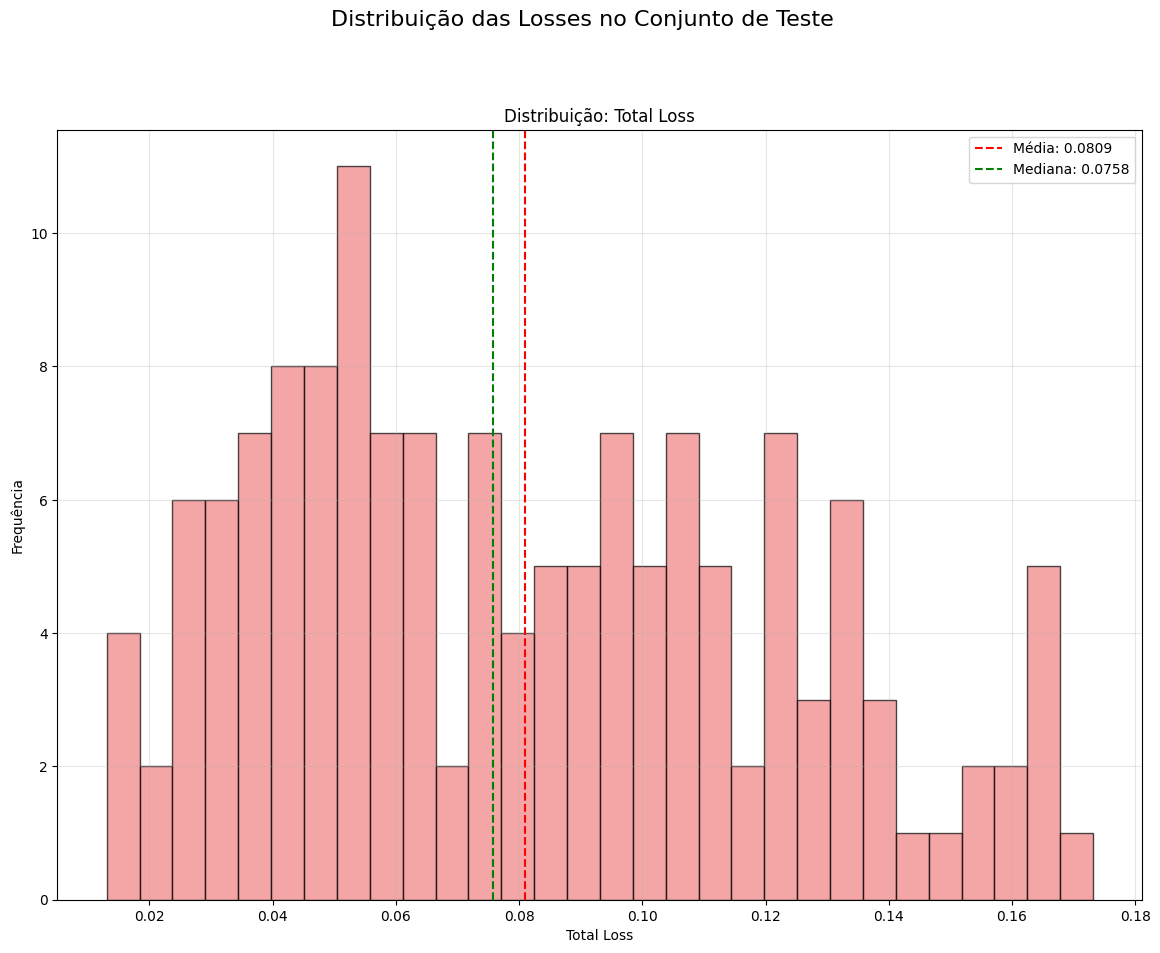

✓ Gráfico salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold5\keypoint_analysis.png


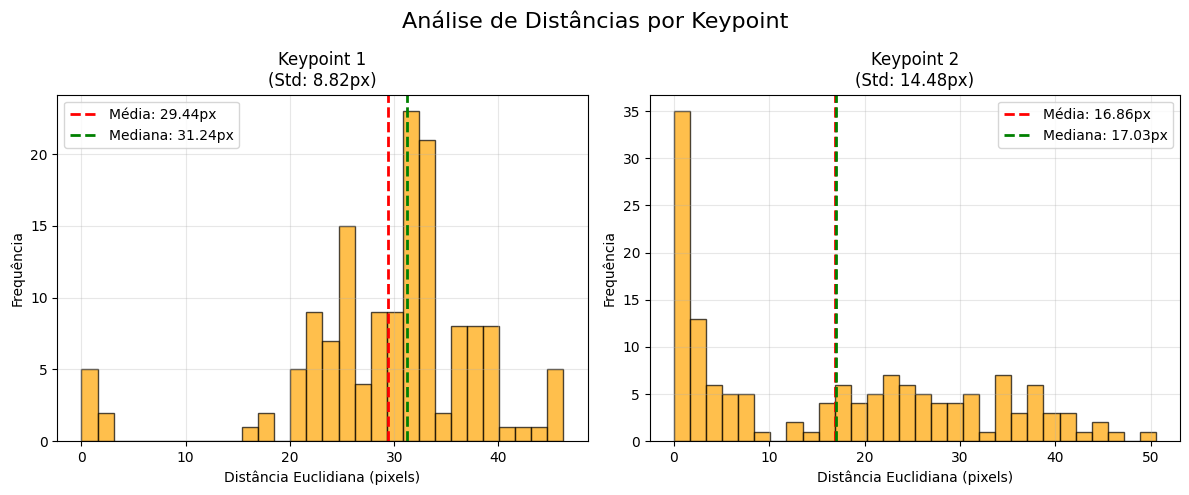


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold5\predictions_by_distance_keypoint1.png


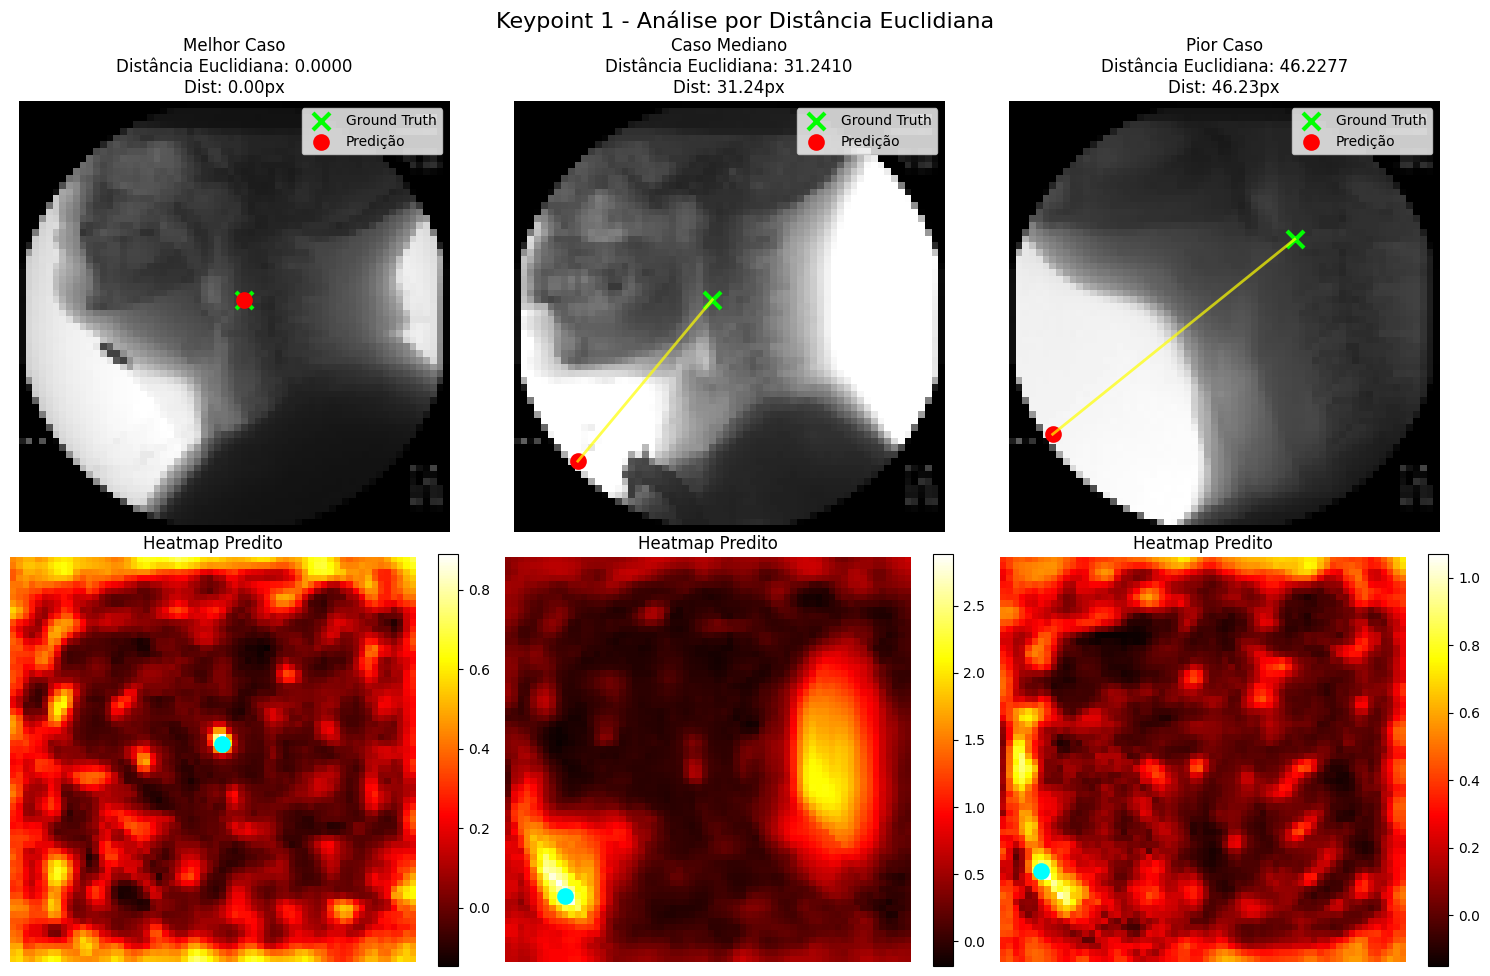


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold5\predictions_by_distance_keypoint2.png


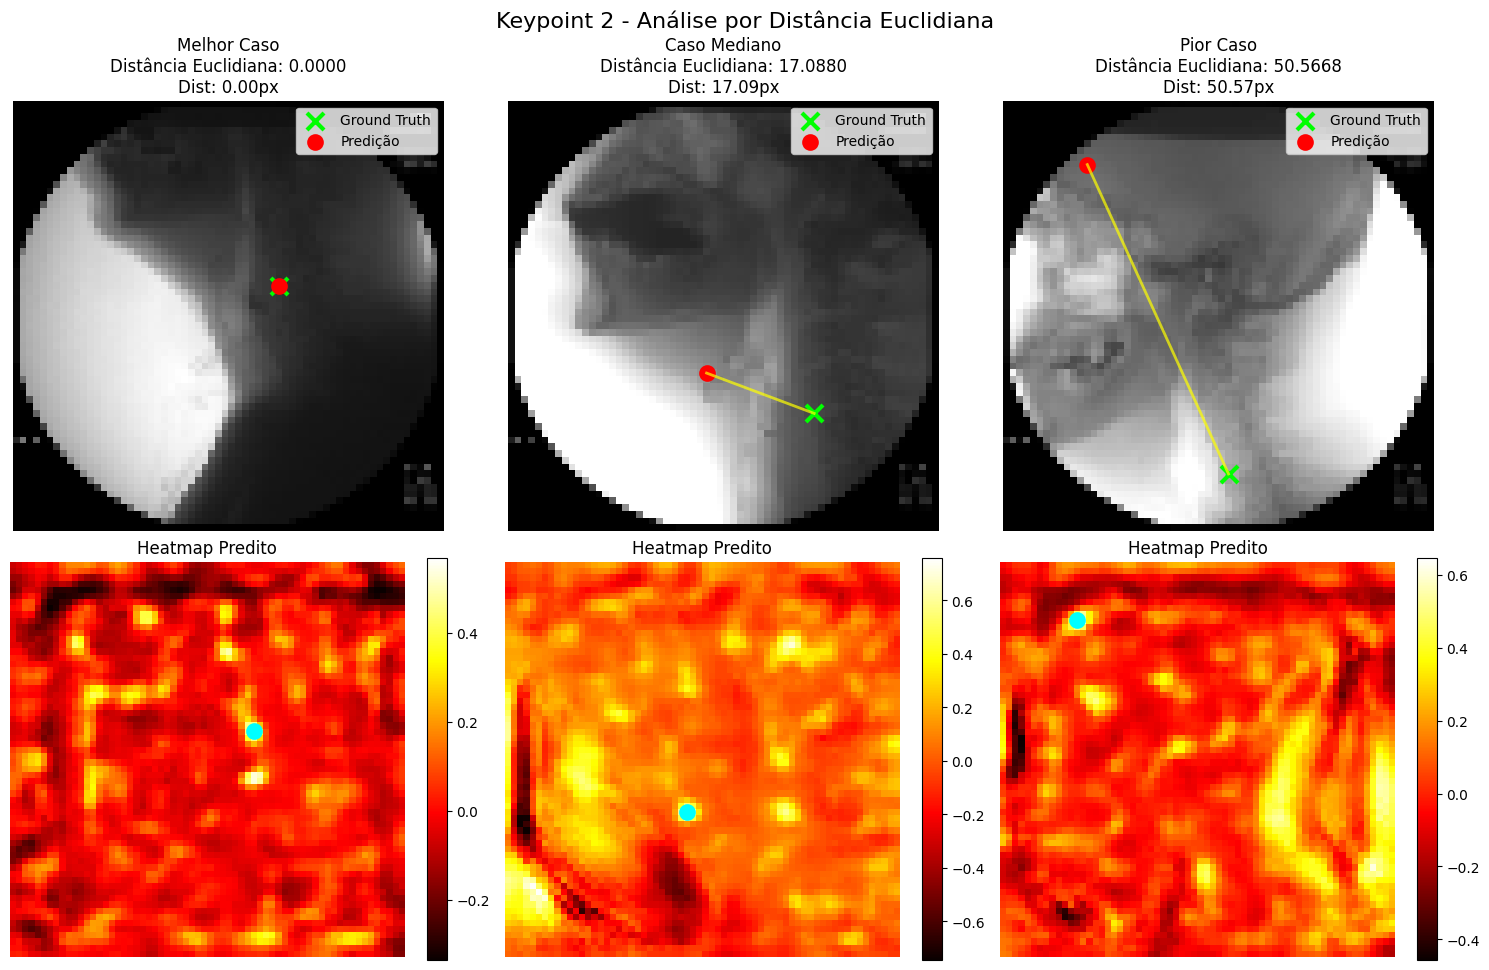


--- Visualizações para Keypoint 1 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold5\predictions_by_loss_keypoint1.png


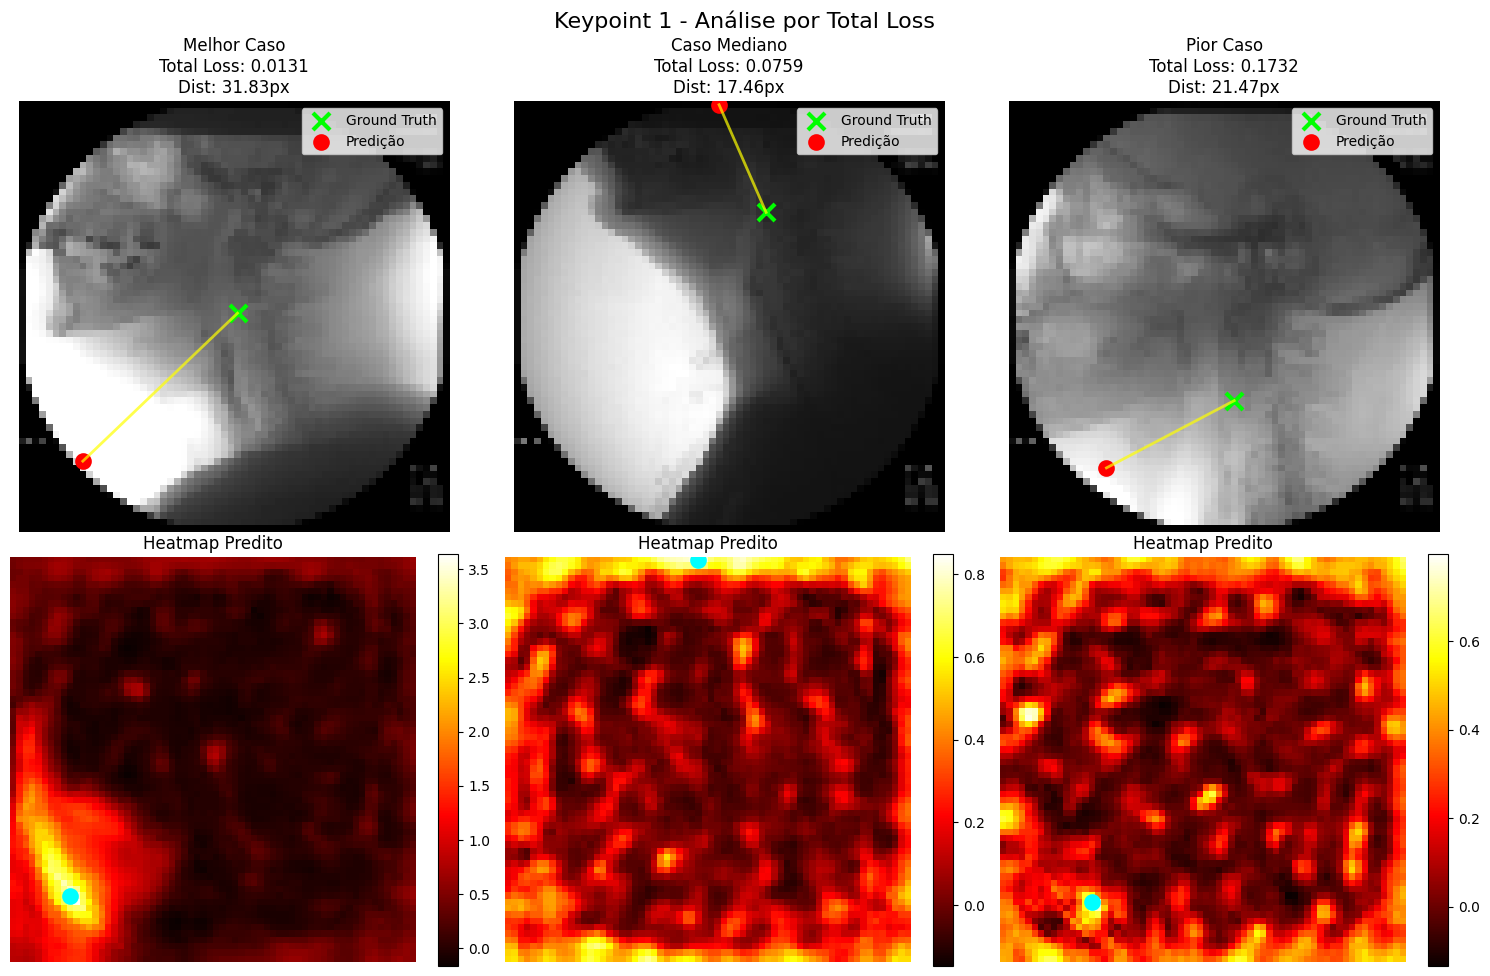


--- Visualizações para Keypoint 2 ---
✓ Figura salva: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold5\predictions_by_loss_keypoint2.png


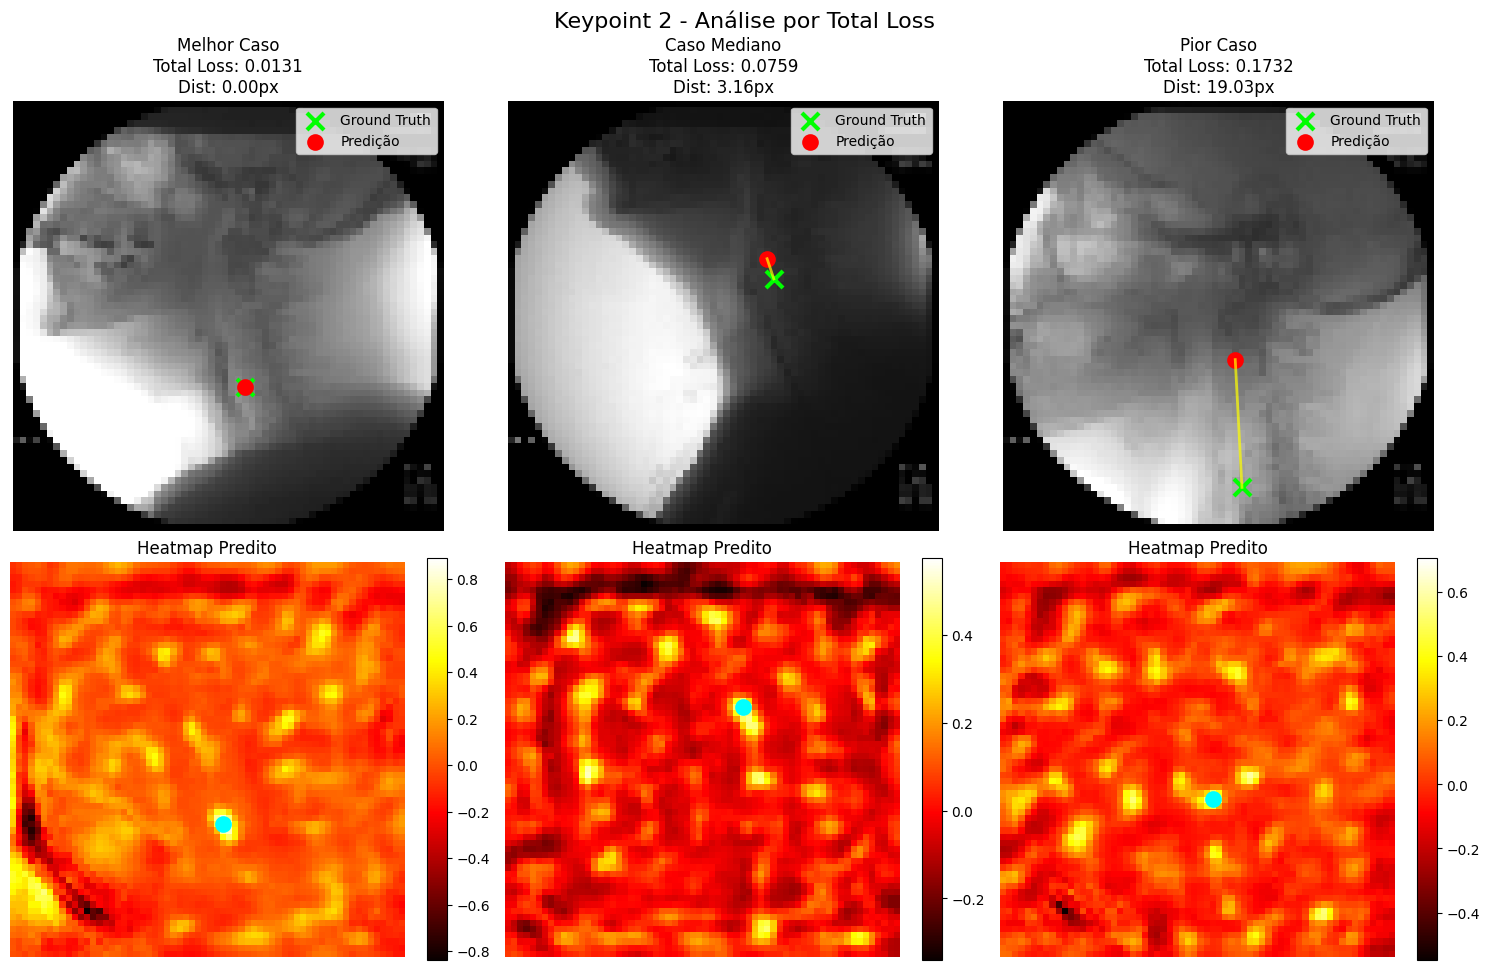

RELATÓRIO DE AVALIAÇÃO NO CONJUNTO DE TESTE

Número de amostras: 146

----------------------------------------------------------------------
LOSS TOTAL
----------------------------------------------------------------------
Média:    0.080898
Mediana:  0.075821
Std:      0.040741
Min:      0.013060
Max:      0.173158

----------------------------------------------------------------------
KEYPOINT 1 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    29.44
Mediana:  31.24
Std:      8.82
Min:      0.00
Max:      46.23
Quartis:  Q1=25.09, Q3=33.30

----------------------------------------------------------------------
KEYPOINT 2 - DISTÂNCIA EUCLIDIANA (pixels)
----------------------------------------------------------------------
Média:    16.86
Mediana:  17.03
Std:      14.48
Min:      0.00
Max:      50.57
Quartis:  Q1=2.00, Q3=28.88


✓ Relatório salvo: ..\..\figs\hrnet_complete\FocalMSEMaskedLoss_200ep\fold5\evaluation_report.

In [16]:
# APLICAÇÃO - TESTE
# ============================================================================

for fold_idx in range(len(list_df_folds)):

    # Carrega melhor modelo de cada fold
    checkpoint_path = f"..\\..\\data\\model_weights\\hrnet_complete\\FocalMSEMaskedLoss_200ep\\fold_{fold_idx+1}_best.pth"
    
    # Cria dataset de teste
    test_dataset = VFSSImageDataset(
        video_frame_df=df_test,
        target="heatmap+roi+points",
        output_dim=(256, 256),
        sigma = sigma_heatmap
    )
    
    model_kwargs = get_default_config()

    # Executa avaliação completa
    results = evaluate_model_on_test(
        model_class=HRNet,
        model_kwargs=model_kwargs,
        checkpoint_path=checkpoint_path,
        test_dataset=test_dataset,
        config=config,
        modify_input_fn=modify_input,
        output_dir=f"..\\..\\figs\\hrnet_complete\\FocalMSEMaskedLoss_200ep\\fold{fold_idx+1}"
    )
    